### Entendimiento de los datos y EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv("sales_train.csv")
test  = pd.read_csv("test.csv")

train.columns = train.columns.str.strip()
test.columns  = test.columns.str.strip()

print("train shape:", train.shape)
print("test  shape:", test.shape)

display(train.head())
display(test.head())


train shape: (2935849, 6)
test  shape: (214200, 3)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [2]:
data_dict = pd.DataFrame({
    "col": train.columns,
    "meaning": [
        "Fecha (día) de la transacción",
        "Índice de mes (0 = primer mes del dataset, 1 = segundo, ...)",
        "ID de tienda/sucursal",
        "ID de producto",
        "Precio observado del producto en esa transacción",
        "Unidades vendidas ese día (puede ser negativa por devoluciones)"
    ]
})
display(data_dict)


,col,meaning
0,date,Fecha (día) de la transacción
1,date_block_num,"Índice de mes (0 = primer mes del dataset, 1 =..."
2,shop_id,ID de tienda/sucursal
3,item_id,ID de producto
4,item_price,Precio observado del producto en esa transacción
5,item_cnt_day,Unidades vendidas ese día (puede ser negativa ...


In [3]:
print(train.info())

nulls = (train.isna().mean().sort_values(ascending=False) * 100).to_frame("% null")
display(nulls)

nulls_test = (test.isna().mean().sort_values(ascending=False) * 100).to_frame("% null")
display(nulls_test)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None


,% null
date,0.0
date_block_num,0.0
shop_id,0.0
item_id,0.0
item_price,0.0
item_cnt_day,0.0


,% null
ID,0.0
shop_id,0.0
item_id,0.0


In [4]:
# Convertibles a numérico (sin modificar aún, solo para revisar)
num_cols = ["date_block_num","shop_id","item_id","item_price","item_cnt_day"]
tmp = train[num_cols].apply(pd.to_numeric, errors="coerce")

print("min/max:")
display(pd.DataFrame({"min": tmp.min(), "max": tmp.max(), "n_nan": tmp.isna().sum()}))


min/max:


,min,max,n_nan
date_block_num,0.0,33.0,0
shop_id,0.0,59.0,0
item_id,0.0,22169.0,0
item_price,-1.0,307980.0,0
item_cnt_day,-22.0,2169.0,0


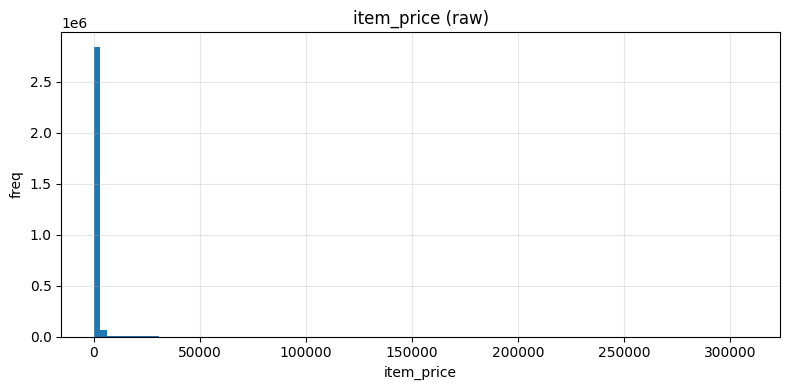

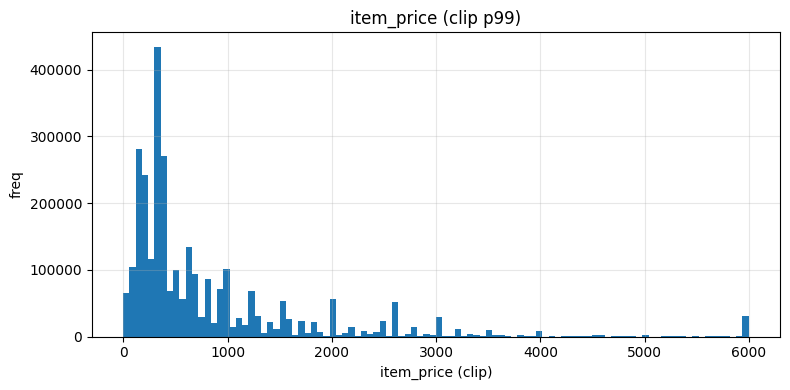

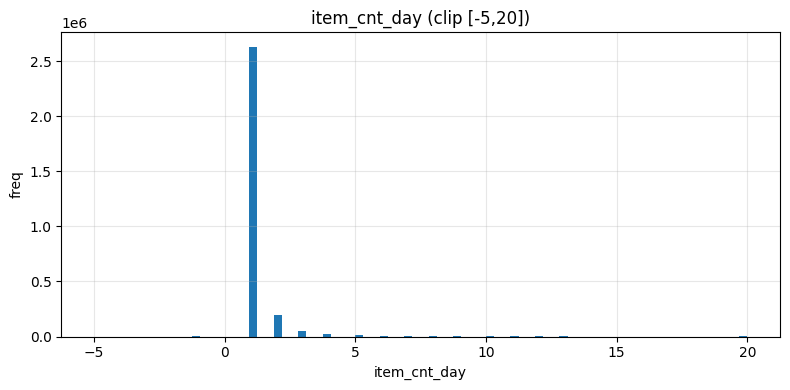

Proporción devoluciones (item_cnt_day < 0): 0.0025055784544777337


In [5]:
tmp = train.copy()
tmp["item_price"] = pd.to_numeric(tmp["item_price"], errors="coerce")
tmp["item_cnt_day"] = pd.to_numeric(tmp["item_cnt_day"], errors="coerce")

# Precio (raw + zoom p99)
p = tmp["item_price"].dropna()

plt.figure(figsize=(8,4))
plt.hist(p, bins=100)
plt.title("item_price (raw)")
plt.xlabel("item_price")
plt.ylabel("freq")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.hist(p.clip(upper=p.quantile(0.99)), bins=100)
plt.title("item_price (clip p99)")
plt.xlabel("item_price (clip)")
plt.ylabel("freq")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Cantidad diaria (zoom)
c = tmp["item_cnt_day"].dropna()

plt.figure(figsize=(8,4))
plt.hist(c.clip(-5, 20), bins=80)
plt.title("item_cnt_day (clip [-5,20])")
plt.xlabel("item_cnt_day")
plt.ylabel("freq")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Proporción devoluciones (item_cnt_day < 0):", (c < 0).mean())


date range: 2013-01-01 00:00:00 -> 2015-10-31 00:00:00
date_block_num range: 0 -> 33
n meses distintos: 34


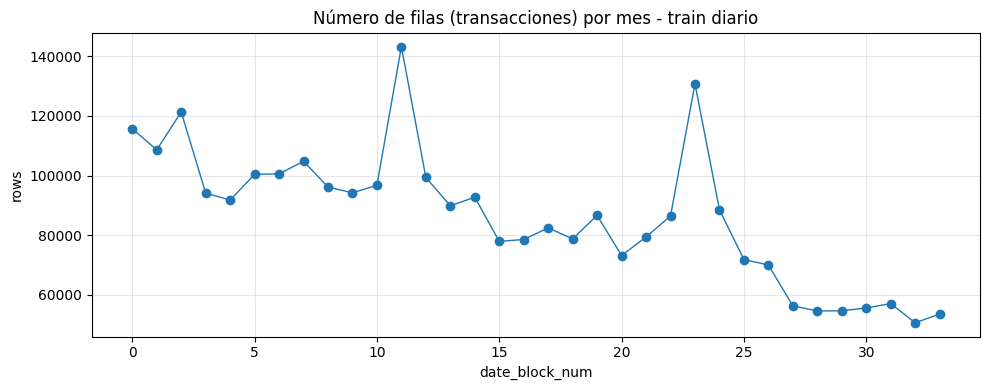

In [6]:
tmp = train.copy()
tmp["date"] = pd.to_datetime(tmp["date"], format="%d.%m.%Y", errors="coerce")

print("date range:", tmp["date"].min(), "->", tmp["date"].max())
print("date_block_num range:", tmp["date_block_num"].min(), "->", tmp["date_block_num"].max())
print("n meses distintos:", tmp["date_block_num"].nunique())

# filas por mes (diario)
m_rows = tmp.groupby("date_block_num").size()

plt.figure(figsize=(10,4))
plt.plot(m_rows.index, m_rows.values, marker="o", linewidth=1)
plt.title("Número de filas (transacciones) por mes - train diario")
plt.xlabel("date_block_num")
plt.ylabel("rows")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [7]:
tmp = train.copy()
tmp["item_cnt_day"] = pd.to_numeric(tmp["item_cnt_day"], errors="coerce").fillna(0)
tmp["item_price"]   = pd.to_numeric(tmp["item_price"], errors="coerce")

monthly = (
    tmp.groupby(["date_block_num","shop_id","item_id"], as_index=False)
       .agg(item_cnt_month=("item_cnt_day","sum"),
            price_mean=("item_price","mean"))
)

# target mensual (como se evalúa)
monthly["item_cnt_month_clip"] = monthly["item_cnt_month"].clip(0, 20)

print("monthly shape:", monthly.shape)
display(monthly.head())


monthly shape: (1609124, 6)


,date_block_num,shop_id,item_id,item_cnt_month,price_mean,item_cnt_month_clip
0,0,0,32,6.0,221.0,6.0
1,0,0,33,3.0,347.0,3.0
2,0,0,35,1.0,247.0,1.0
3,0,0,43,1.0,221.0,1.0
4,0,0,51,2.0,128.5,2.0


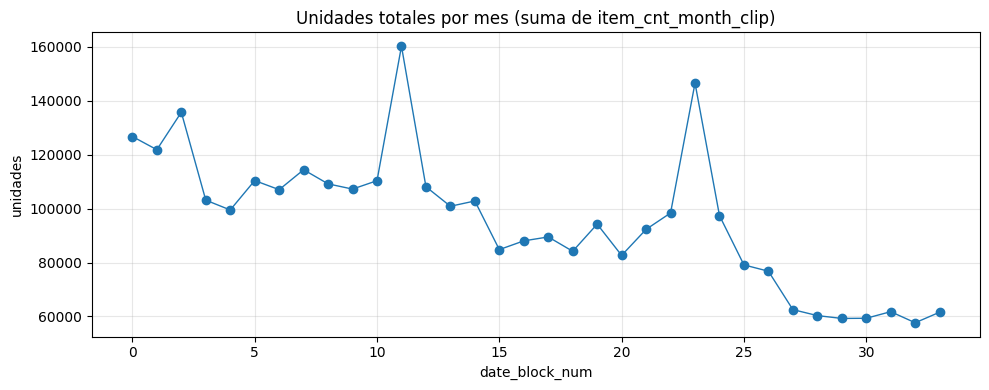

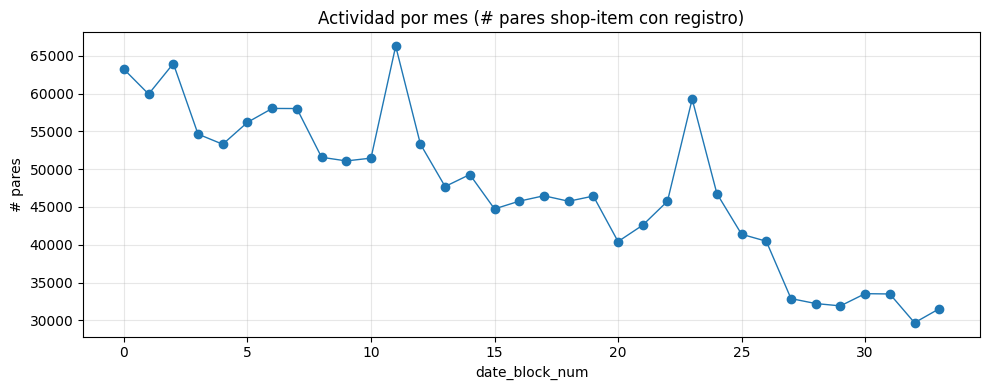

In [8]:
m_units = monthly.groupby("date_block_num")["item_cnt_month_clip"].sum()
m_pairs = monthly.groupby("date_block_num").size()

plt.figure(figsize=(10,4))
plt.plot(m_units.index, m_units.values, marker="o", linewidth=1)
plt.title("Unidades totales por mes (suma de item_cnt_month_clip)")
plt.xlabel("date_block_num")
plt.ylabel("unidades")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(m_pairs.index, m_pairs.values, marker="o", linewidth=1)
plt.title("Actividad por mes (# pares shop-item con registro)")
plt.xlabel("date_block_num")
plt.ylabel("# pares")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


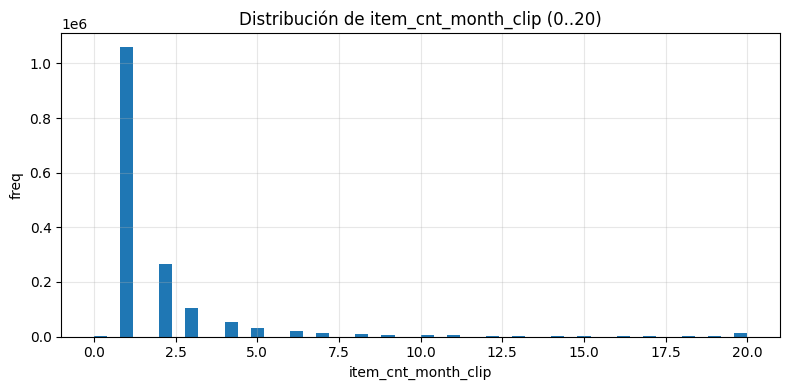

Proporción de ceros (en monthly observado): 0.002173853599846873
Pares únicos (shop,item) observados en train: 424124
Pares únicos en test: 214200


In [9]:
y = monthly["item_cnt_month_clip"]
plt.figure(figsize=(8,4))
plt.hist(y, bins=50)
plt.title("Distribución de item_cnt_month_clip (0..20)")
plt.xlabel("item_cnt_month_clip")
plt.ylabel("freq")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Proporción de ceros (en monthly observado):", (y == 0).mean())

# Cuántos pares aparecen en total
n_pairs_total = monthly[["shop_id","item_id"]].drop_duplicates().shape[0]
print("Pares únicos (shop,item) observados en train:", n_pairs_total)
print("Pares únicos en test:", test[["shop_id","item_id"]].drop_duplicates().shape[0])


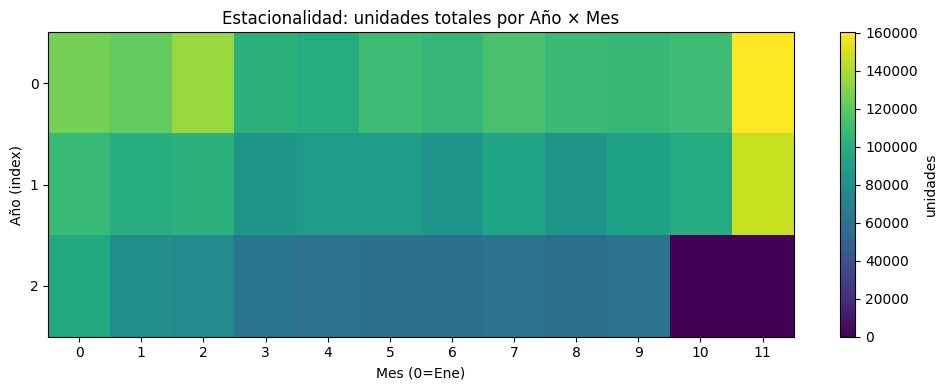

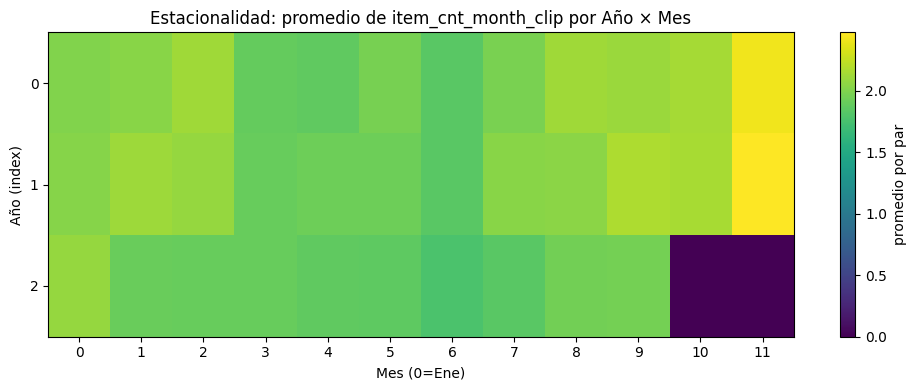

In [10]:
monthly["month"] = (monthly["date_block_num"] % 12).astype(int)
monthly["year"]  = (monthly["date_block_num"] // 12).astype(int)

# Opción 1: estacionalidad en unidades totales por (año, mes)
season = monthly.groupby(["year","month"])["item_cnt_month_clip"].sum().unstack("month").fillna(0)

plt.figure(figsize=(10,4))
plt.imshow(season.values, aspect="auto")
plt.title("Estacionalidad: unidades totales por Año × Mes")
plt.xlabel("Mes (0=Ene)")
plt.ylabel("Año (index)")
plt.xticks(range(12), range(12))
plt.yticks(range(len(season.index)), season.index)
plt.colorbar(label="unidades")
plt.tight_layout()
plt.show()

# Opción 2 (a veces mejor): promedio de ventas por par activo (normaliza actividad)
season_mean = monthly.groupby(["year","month"])["item_cnt_month_clip"].mean().unstack("month").fillna(0)

plt.figure(figsize=(10,4))
plt.imshow(season_mean.values, aspect="auto")
plt.title("Estacionalidad: promedio de item_cnt_month_clip por Año × Mes")
plt.xlabel("Mes (0=Ene)")
plt.ylabel("Año (index)")
plt.xticks(range(12), range(12))
plt.yticks(range(len(season_mean.index)), season_mean.index)
plt.colorbar(label="promedio por par")
plt.tight_layout()
plt.show()

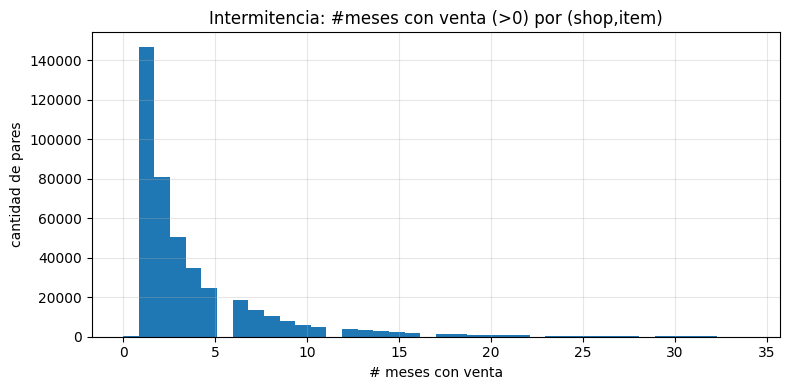

Percentiles #meses con venta: {0.5: 2.0, 0.75: 5.0, 0.9: 9.0, 0.95: 12.0, 0.99: 21.0}


In [11]:
# months con ventas (>0) por (shop,item)
m2 = monthly.copy()
m2["sold"] = (m2["item_cnt_month_clip"] > 0).astype(int)

months_sold = (m2.groupby(["shop_id","item_id"])["sold"].sum())

plt.figure(figsize=(8,4))
plt.hist(months_sold, bins=40)
plt.title("Intermitencia: #meses con venta (>0) por (shop,item)")
plt.xlabel("# meses con venta")
plt.ylabel("cantidad de pares")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Percentiles #meses con venta:", months_sold.quantile([0.5,0.75,0.9,0.95,0.99]).to_dict())


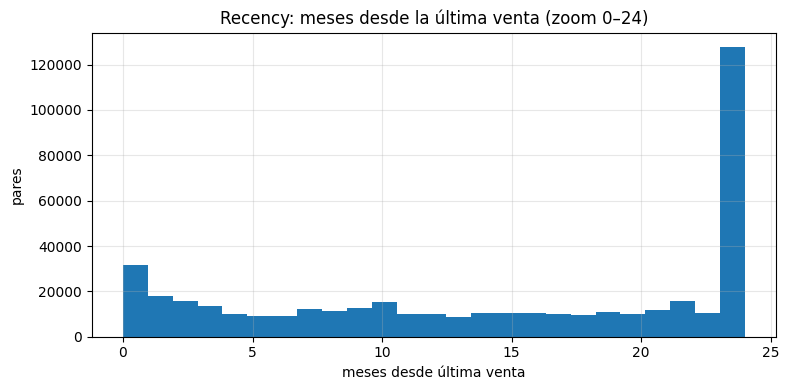

In [12]:
max_m = int(monthly["date_block_num"].max())

# último mes vendido por par (en todo train)
last_sale = (monthly.loc[monthly["item_cnt_month_clip"] > 0]
                  .groupby(["shop_id","item_id"])["date_block_num"].max())

# recency en el último mes observado
recency = (max_m - last_sale).reindex(
    monthly[["shop_id","item_id"]].drop_duplicates().set_index(["shop_id","item_id"]).index
)

recency = recency.fillna(max_m + 1)  # nunca vendió -> muy grande

plt.figure(figsize=(8,4))
plt.hist(recency.clip(0, 24), bins=25)  # zoom
plt.title("Recency: meses desde la última venta (zoom 0–24)")
plt.xlabel("meses desde última venta")
plt.ylabel("pares")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


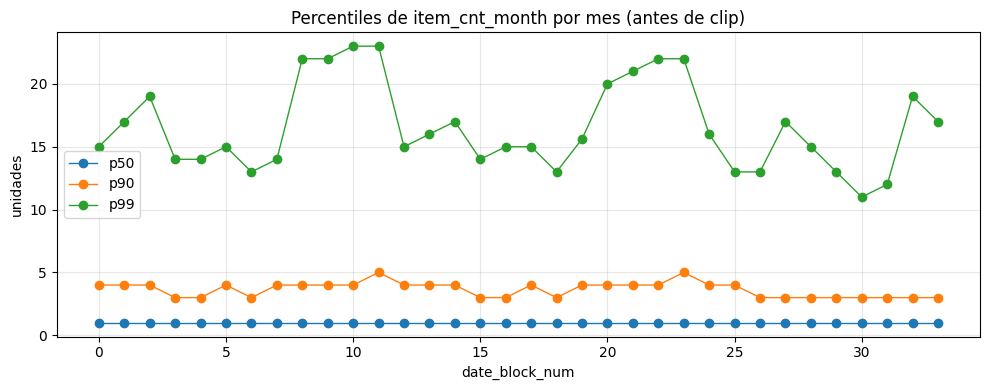

In [13]:
q = (monthly.groupby("date_block_num")["item_cnt_month"]
            .quantile([0.5, 0.9, 0.99])
            .unstack())

plt.figure(figsize=(10,4))
plt.plot(q.index, q[0.5], marker="o", linewidth=1, label="p50")
plt.plot(q.index, q[0.9], marker="o", linewidth=1, label="p90")
plt.plot(q.index, q[0.99], marker="o", linewidth=1, label="p99")
plt.title("Percentiles de item_cnt_month por mes (antes de clip)")
plt.xlabel("date_block_num")
plt.ylabel("unidades")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


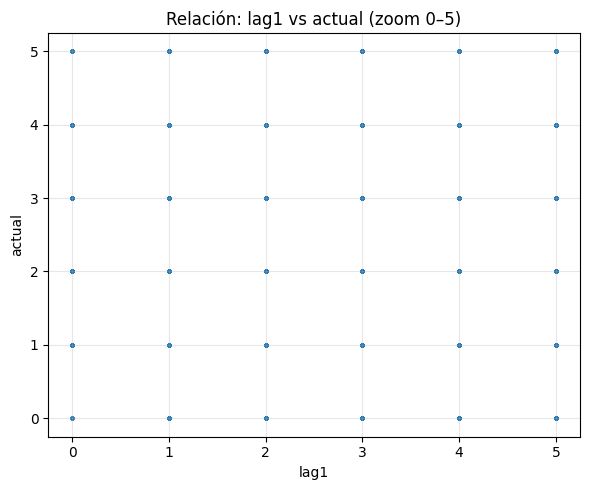

In [14]:
m3 = monthly.sort_values(["shop_id","item_id","date_block_num"]).copy()
m3["lag1"] = m3.groupby(["shop_id","item_id"])["item_cnt_month_clip"].shift(1)
tmp = m3.dropna(subset=["lag1"])

plt.figure(figsize=(6,5))
plt.scatter(tmp["lag1"].clip(0,5), tmp["item_cnt_month_clip"].clip(0,5), s=4, alpha=0.15)
plt.title("Relación: lag1 vs actual (zoom 0–5)")
plt.xlabel("lag1")
plt.ylabel("actual")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Feature engineering

In [15]:
import numpy as np
import pandas as pd
import gc

# =========================
# 1) Cargar
# =========================
train = pd.read_csv("sales_train.csv")
test  = pd.read_csv("test.csv")
train.columns = train.columns.str.strip()
test.columns  = test.columns.str.strip()

# Tipos
train["date_block_num"] = pd.to_numeric(train["date_block_num"], errors="coerce")
train["shop_id"]        = pd.to_numeric(train["shop_id"], errors="coerce")
train["item_id"]        = pd.to_numeric(train["item_id"], errors="coerce")
train["item_price"]     = pd.to_numeric(train["item_price"], errors="coerce")
train["item_cnt_day"]   = pd.to_numeric(train["item_cnt_day"], errors="coerce")

test["ID"]      = pd.to_numeric(test["ID"], errors="coerce")
test["shop_id"] = pd.to_numeric(test["shop_id"], errors="coerce")
test["item_id"] = pd.to_numeric(test["item_id"], errors="coerce")

train = train.dropna(subset=["date_block_num","shop_id","item_id","item_price","item_cnt_day"])
test  = test.dropna(subset=["ID","shop_id","item_id"])

# Cast compacto
train["date_block_num"] = train["date_block_num"].astype(np.int16)
train["shop_id"] = train["shop_id"].astype(np.int16)
train["item_id"] = train["item_id"].astype(np.int16)
test["ID"] = test["ID"].astype(np.int32)
test["shop_id"] = test["shop_id"].astype(np.int16)
test["item_id"] = test["item_id"].astype(np.int16)

# =========================
# 2) Tratamiento mínimo (valores especiales) para poder modelar
#    (más “fino” lo harás en Notebook 2)
# =========================
# Precio negativo (p.ej. -1) -> inválido
train = train[train["item_price"] >= 0]

# Outliers extremos (suave)
train = train[train["item_price"] < 100000]
train = train[(train["item_cnt_day"] > -1000) & (train["item_cnt_day"] < 1000)]

# =========================
# 3) Agregación mensual
# =========================
monthly = (
    train.groupby(["date_block_num","shop_id","item_id"], as_index=False)
         .agg(
             item_cnt_month=("item_cnt_day","sum"),
             price_mean=("item_price","mean"),
         )
)

# clip target (tal como se suele hacer en esta comp)
monthly["item_cnt_month"] = monthly["item_cnt_month"].clip(0, 20).astype(np.float32)
monthly["price_mean"] = monthly["price_mean"].astype(np.float32)

max_block  = int(monthly["date_block_num"].max())  # debe ser 33
test_block = max_block + 1                         # 34

# =========================
# 4) Agregados laggeados (global / item / shop)
#    IMPORTANT: shift por +1 mes para evitar leakage
# =========================
global_agg = (
    monthly.groupby("date_block_num", as_index=False)
           .agg(global_mean=("item_cnt_month","mean"),
                global_sum=("item_cnt_month","sum"),
                global_pairs=("item_cnt_month","size"))
)
global_agg["date_block_num"] = (global_agg["date_block_num"] + 1).astype(np.int16)

item_agg = (
    monthly.groupby(["date_block_num","item_id"], as_index=False)
           .agg(item_mean=("item_cnt_month","mean"),
                item_shops=("shop_id","nunique"),
                item_price_mean=("price_mean","mean"))
)
item_agg["date_block_num"] = (item_agg["date_block_num"] + 1).astype(np.int16)

shop_agg = (
    monthly.groupby(["date_block_num","shop_id"], as_index=False)
           .agg(shop_mean=("item_cnt_month","mean"),
                shop_items=("item_id","nunique"))
)
shop_agg["date_block_num"] = (shop_agg["date_block_num"] + 1).astype(np.int16)

# =========================
# 5) Panel denso SOLO para pares del test (maneja sparsity)
# =========================
test_pairs = test[["shop_id","item_id"]].drop_duplicates()
n_pairs = len(test_pairs)

months = np.arange(0, test_block + 1, dtype=np.int16)  # 0..34
n_months = len(months)

panel = pd.DataFrame({
    "date_block_num": np.tile(months, n_pairs).astype(np.int16),
    "shop_id": np.repeat(test_pairs["shop_id"].values, n_months).astype(np.int16),
    "item_id": np.repeat(test_pairs["item_id"].values, n_months).astype(np.int16),
})

# Merge target/price mensual
panel = panel.merge(
    monthly[["date_block_num","shop_id","item_id","item_cnt_month","price_mean"]],
    on=["date_block_num","shop_id","item_id"],
    how="left"
)

# Target: meses sin registro => 0 (esto es CLAVE)
panel["item_cnt_month"] = panel["item_cnt_month"].fillna(0).astype(np.float32)

# Precio: dejamos NaN cuando no hubo venta (mejor que poner 0)
# price_mean se queda NaN si no hubo registro
panel["price_mean"] = panel["price_mean"].astype(np.float32)

# Calendar
panel["month"] = (panel["date_block_num"] % 12).astype(np.int8)
panel["year"]  = (panel["date_block_num"] // 12).astype(np.int8)

# Encoding cíclico (estacionalidad)
panel["month_sin"] = np.sin(2*np.pi*panel["month"]/12).astype(np.float32)
panel["month_cos"] = np.cos(2*np.pi*panel["month"]/12).astype(np.float32)

# Merge agregados laggeados
panel = panel.merge(global_agg, on="date_block_num", how="left")
panel = panel.merge(item_agg,   on=["date_block_num","item_id"], how="left")
panel = panel.merge(shop_agg,   on=["date_block_num","shop_id"], how="left")

# Fill NaNs de agregados (si no existe info previa)
for c in ["global_mean","global_sum","global_pairs","item_mean","item_shops","item_price_mean","shop_mean","shop_items"]:
    panel[c] = panel[c].fillna(0).astype(np.float32)

# Limpieza de memoria
del train, monthly, global_agg, item_agg, shop_agg, test_pairs
gc.collect()

# =========================
# 6) Precio: clip/log + "último precio conocido" (laggeado)
# =========================
# clip price por percentil (sobre valores observados)
p_obs = panel["price_mean"].dropna()
p999 = p_obs.quantile(0.999) if len(p_obs) else 0.0

price_clip = panel["price_mean"].clip(0, p999)
panel["log_price_obs"] = np.where(panel["price_mean"].notna(), np.log1p(price_clip), np.nan).astype(np.float32)

# item_price_mean (laggeado) también en log
panel["item_log_price_mean"] = np.log1p(panel["item_price_mean"].clip(0, p999)).astype(np.float32)

# Orden para operaciones por grupo
panel.sort_values(["shop_id","item_id","date_block_num"], inplace=True, ignore_index=True)
g = panel.groupby(["shop_id","item_id"], sort=False)

# Último precio observado antes de t
panel["log_price_last"] = (
    g["log_price_obs"].ffill()            # arrastra último observado
)
panel["log_price_last"] = (
    g["log_price_last"].shift(1)          # lo convierte en "estrictamente pasado"
    .astype(np.float32)
)

panel["price_missing_last"] = panel["log_price_last"].isna().astype(np.int8)

# Imputación suave: si nunca tuvo precio, usa el promedio del item (laggeado)
panel["log_price_last"] = panel["log_price_last"].fillna(panel["item_log_price_mean"]).astype(np.float32)

panel["price_gap_item"] = (panel["log_price_last"] - panel["item_log_price_mean"]).astype(np.float32)

# =========================
# 7) Lags del target (1..6 y 12)
# =========================
for lag in [1,2,3,4,5,6,12]:
    panel[f"cnt_lag_{lag}"] = g["item_cnt_month"].shift(lag).fillna(0).astype(np.float32)

# =========================
# 8) Ventanas (desde lags, sin rolling pesado)
# =========================
eps = 1e-6
l1 = panel["cnt_lag_1"]; l2 = panel["cnt_lag_2"]; l3 = panel["cnt_lag_3"]
l4 = panel["cnt_lag_4"]; l5 = panel["cnt_lag_5"]; l6 = panel["cnt_lag_6"]
l12 = panel["cnt_lag_12"]

# last 3
panel["sum_3"]  = (l1 + l2 + l3).astype(np.float32)
panel["mean_3"] = (panel["sum_3"] / 3.0).astype(np.float32)
panel["max_3"]  = np.maximum.reduce([l1.values, l2.values, l3.values]).astype(np.float32)
panel["nz_3"]   = ((l1>0).astype(np.int8) + (l2>0).astype(np.int8) + (l3>0).astype(np.int8)).astype(np.int8)

mean_sq_3 = ((l1*l1 + l2*l2 + l3*l3) / 3.0).astype(np.float32)
panel["std_3"] = np.sqrt(np.maximum(mean_sq_3 - panel["mean_3"]*panel["mean_3"], 0)).astype(np.float32)

# last 6
panel["sum_6"]  = (l1+l2+l3+l4+l5+l6).astype(np.float32)
panel["mean_6"] = (panel["sum_6"]/6.0).astype(np.float32)
panel["max_6"]  = np.maximum.reduce([l1.values,l2.values,l3.values,l4.values,l5.values,l6.values]).astype(np.float32)
panel["nz_6"]   = ((l1>0)+(l2>0)+(l3>0)+(l4>0)+(l5>0)+(l6>0)).astype(np.int8)

mean_sq_6 = ((l1*l1+l2*l2+l3*l3+l4*l4+l5*l5+l6*l6) / 6.0).astype(np.float32)
panel["std_6"] = np.sqrt(np.maximum(mean_sq_6 - panel["mean_6"]*panel["mean_6"], 0)).astype(np.float32)

# Intermitencia (probabilidad y tamaño)
panel["rate_6"] = (panel["nz_6"] / 6.0).astype(np.float32)
panel["mean_nonzero_6"] = (panel["sum_6"] / (panel["nz_6"].astype(np.float32) + eps)).astype(np.float32)
panel["interval_6"] = (6.0 / (panel["nz_6"].astype(np.float32) + eps)).astype(np.float32)

# Régimen
panel["active_1"] = (l1 > 0).astype(np.int8)
panel["dead_6"]   = (panel["nz_6"] == 0).astype(np.int8)

# Tendencias / estacionalidad
panel["trend_1_3"]  = (l1 - l3).astype(np.float32)
panel["trend_1_12"] = (l1 - l12).astype(np.float32)
panel["ratio_1_12"] = (l1 / (l12 + eps)).astype(np.float32)

# =========================
# 9) Recency EXACTA (meses desde última venta)
# =========================
sale_month = panel["date_block_num"].where(panel["item_cnt_month"] > 0, np.nan)

# último mes con venta "hasta ahora"
last_sale_inclusive = sale_month.groupby([panel["shop_id"], panel["item_id"]]).ffill()
# último mes con venta estrictamente pasado
panel["last_sale_month"] = last_sale_inclusive.groupby([panel["shop_id"], panel["item_id"]]).shift(1)

panel["recency"] = (panel["date_block_num"] - panel["last_sale_month"]).fillna(99).clip(0, 99).astype(np.int16)
panel.drop(columns=["last_sale_month"], inplace=True)

# =========================
# 10) Cumulativos (hasta t-1)
# =========================
panel["sold"] = (panel["item_cnt_month"] > 0).astype(np.int8)
panel["sold_cum"] = g["sold"].cumsum().astype(np.int16)
panel["sold_cum_lag1"] = g["sold_cum"].shift(1).fillna(0).astype(np.int16)

panel["sales_cum"] = g["item_cnt_month"].cumsum().astype(np.float32)
panel["sales_cum_lag1"] = g["sales_cum"].shift(1).fillna(0).astype(np.float32)
panel["log_sales_cum_lag1"] = np.log1p(panel["sales_cum_lag1"]).astype(np.float32)

panel["never_sold_before"] = (panel["sold_cum_lag1"] == 0).astype(np.int8)

# =========================
# 11) Split train/valid/test
# =========================
train_df = panel[panel["date_block_num"] <= max_block - 1].copy()  # 0..32
valid_df = panel[panel["date_block_num"] == max_block].copy()      # 33
test_df  = panel[panel["date_block_num"] == test_block].copy()     # 34

y_train = train_df["item_cnt_month"].astype(np.float32)
y_valid = valid_df["item_cnt_month"].astype(np.float32)

# Features finales (compactas + potentes)
feature_cols = [
    "date_block_num","month","year","month_sin","month_cos","shop_id","item_id",

    # macro / popularidad laggeada
    "global_mean","global_sum","global_pairs",
    "item_mean","item_shops",
    "shop_mean","shop_items",

    # precio
    "log_price_last","item_log_price_mean","price_gap_item","price_missing_last",

    # lags
    "cnt_lag_1","cnt_lag_2","cnt_lag_3","cnt_lag_4","cnt_lag_5","cnt_lag_6","cnt_lag_12",

    # ventanas/intermitencia/régimen
    "sum_3","mean_3","std_3","max_3","nz_3",
    "sum_6","mean_6","std_6","max_6","nz_6",
    "rate_6","mean_nonzero_6","interval_6",
    "active_1","dead_6",

    # recency/trend
    "recency","trend_1_3","trend_1_12","ratio_1_12",

    # historial
    "sold_cum_lag1","log_sales_cum_lag1","never_sold_before",
]

X_train = train_df[feature_cols]
X_valid = valid_df[feature_cols]
X_test  = test_df[feature_cols]

print("Features listos")
print("X_train:", X_train.shape, "X_valid:", X_valid.shape, "X_test:", X_test.shape)
print("Ejemplo columnas:", feature_cols[:10])

# (Opcional) libera memoria
del panel, train_df, valid_df
gc.collect()


Features listos
X_train: (7068600, 47) X_valid: (214200, 47) X_test: (214200, 47)
Ejemplo columnas: ['date_block_num', 'month', 'year', 'month_sin', 'month_cos', 'shop_id', 'item_id', 'global_mean', 'global_sum', 'global_pairs']


0

In [16]:
import os
import json

OUT_DIR = "intermediate_data"
os.makedirs(OUT_DIR, exist_ok=True)

# 1) Guarda datasets
train_out = X_train.copy()
train_out["y"] = y_train.values

valid_out = X_valid.copy()
valid_out["y"] = y_valid.values

test_out = X_test.copy()

# (Opcional pero útil) Guardar shop/item para unir con test.csv después
test_meta = test_df[["shop_id","item_id"]].copy()  # test_df es el del mes test_block
test_meta["ID"] = None  # lo llenaremos al merge con test.csv en Notebook 3

# Parquet comprimido
train_out.to_parquet(f"{OUT_DIR}/train.parquet", index=False)
valid_out.to_parquet(f"{OUT_DIR}/valid.parquet", index=False)
test_out.to_parquet(f"{OUT_DIR}/test_features.parquet", index=False)

# También guarda el mapping shop-item del test mes
test_meta.to_parquet(f"{OUT_DIR}/test_pairs.parquet", index=False)

# 2) Guarda metadata (columnas + params)
meta = {
    "feature_cols": feature_cols,
    "max_block": int(max_block),
    "test_block": int(test_block),
}
with open(f"{OUT_DIR}/meta.json", "w") as f:
    json.dump(meta, f, indent=2)

print("guardado en:", OUT_DIR)
print(os.listdir(OUT_DIR))


guardado en: intermediate_data
['test_pairs.parquet', 'meta.json', 'test_features.parquet', 'valid.parquet', 'train.parquet']


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Si cargaste parquet intermedio:
# train_out = pd.read_parquet("intermediate_data/train.parquet")

df = train_out.copy()  # <- o tu train_df con y
y_col = "y"

df[y_col] = df[y_col].astype(float)


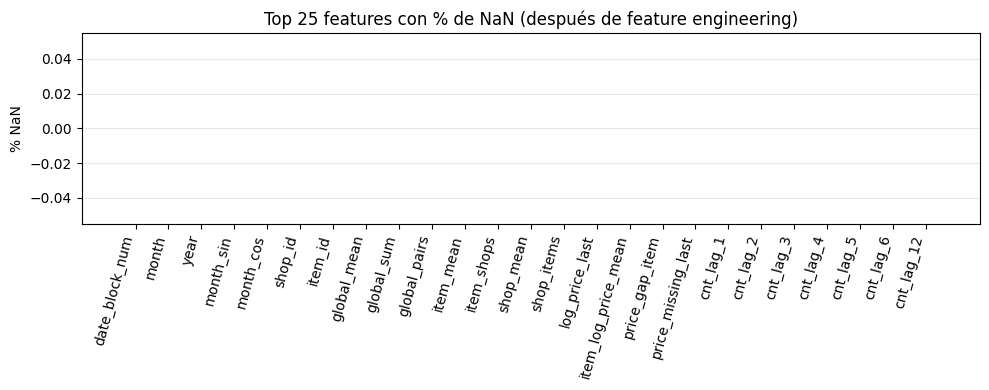

In [18]:
na = (df.isna().mean().sort_values(ascending=False) * 100).head(25)

plt.figure(figsize=(10,4))
plt.bar(na.index.astype(str), na.values)
plt.title("Top 25 features con % de NaN (después de feature engineering)")
plt.ylabel("% NaN")
plt.xticks(rotation=75, ha="right")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2443182026.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby("rec_bin")["sold_now"].mean()


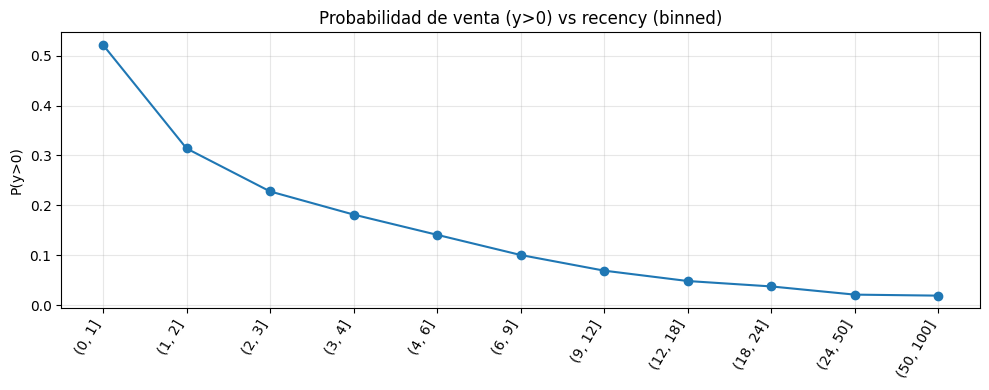

In [19]:
df["sold_now"] = (df[y_col] > 0).astype(int)

# Bins de recency
bins = [-1,0,1,2,3,4,6,9,12,18,24,50,100]
df["rec_bin"] = pd.cut(df["recency"], bins=bins)

grp = df.groupby("rec_bin")["sold_now"].mean()

plt.figure(figsize=(10,4))
plt.plot(grp.index.astype(str), grp.values, marker="o")
plt.title("Probabilidad de venta (y>0) vs recency (binned)")
plt.ylabel("P(y>0)")
plt.xticks(rotation=60, ha="right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


/tmp/ipython-input-390691306.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p_sold = df.groupby("rate_bin")["sold_now"].mean()
/tmp/ipython-input-390691306.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_y = df.groupby("rate_bin")[y_col].mean()


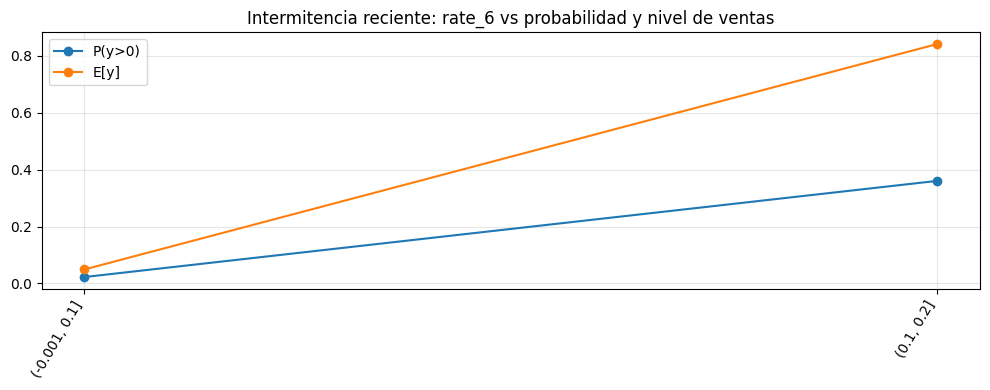

In [20]:
# rate_6 ya está en 0..1
bins = np.linspace(0, 1, 11)
df["rate_bin"] = pd.cut(df["rate_6"], bins=bins, include_lowest=True)

p_sold = df.groupby("rate_bin")["sold_now"].mean()
mean_y = df.groupby("rate_bin")[y_col].mean()

plt.figure(figsize=(10,4))
plt.plot(p_sold.index.astype(str), p_sold.values, marker="o", label="P(y>0)")
plt.plot(mean_y.index.astype(str), mean_y.values, marker="o", label="E[y]")
plt.title("Intermitencia reciente: rate_6 vs probabilidad y nivel de ventas")
plt.xticks(rotation=60, ha="right")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipython-input-2843212975.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=y_col, index="rec_b", columns="rate_b", aggfunc="mean").fillna(0)


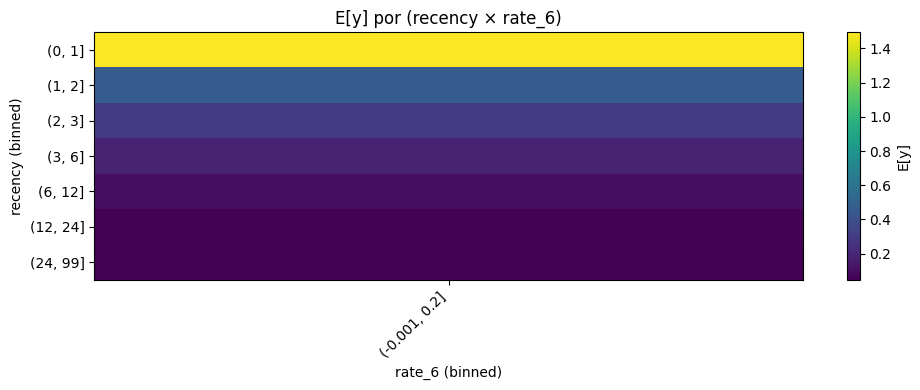

In [21]:
# recency bins y rate bins
df["rec_b"] = pd.cut(df["recency"], bins=[-1,0,1,2,3,6,12,24,99])
df["rate_b"] = pd.cut(df["rate_6"], bins=np.linspace(0,1,6), include_lowest=True)

pivot = df.pivot_table(values=y_col, index="rec_b", columns="rate_b", aggfunc="mean").fillna(0)

plt.figure(figsize=(10,4))
plt.imshow(pivot.values, aspect="auto")
plt.title("E[y] por (recency × rate_6)")
plt.xlabel("rate_6 (binned)")
plt.ylabel("recency (binned)")
plt.xticks(range(len(pivot.columns)), [str(c) for c in pivot.columns], rotation=45, ha="right")
plt.yticks(range(len(pivot.index)), [str(i) for i in pivot.index])
plt.colorbar(label="E[y]")
plt.tight_layout()
plt.show()


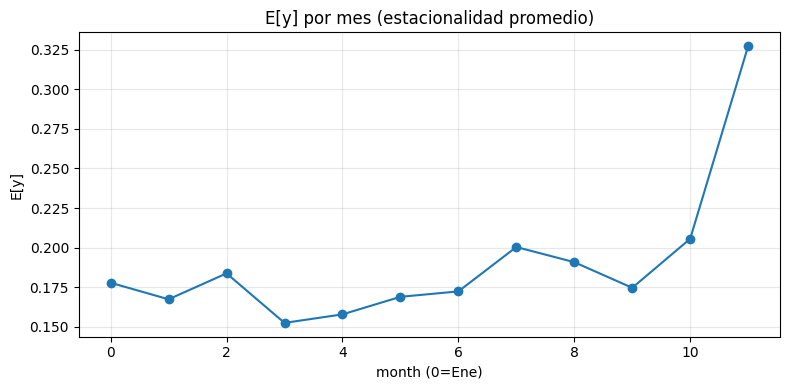

In [22]:
m = df.groupby("month")[y_col].mean()

plt.figure(figsize=(8,4))
plt.plot(m.index, m.values, marker="o")
plt.title("E[y] por mes (estacionalidad promedio)")
plt.xlabel("month (0=Ene)")
plt.ylabel("E[y]")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


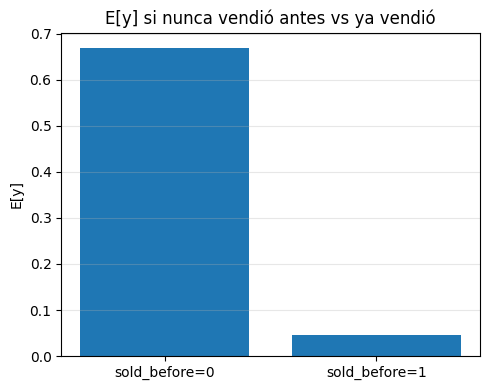

                       mean    count
never_sold_before                   
0                  0.668359  1579701
1                  0.046768  5488899


In [23]:
grp = df.groupby("never_sold_before")[y_col].agg(["mean","count"])

plt.figure(figsize=(5,4))
plt.bar(["sold_before=0","sold_before=1"], grp["mean"].values)
plt.title("E[y] si nunca vendió antes vs ya vendió")
plt.ylabel("E[y]")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print(grp)


/tmp/ipython-input-1800226310.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(bins)[y_col].mean()


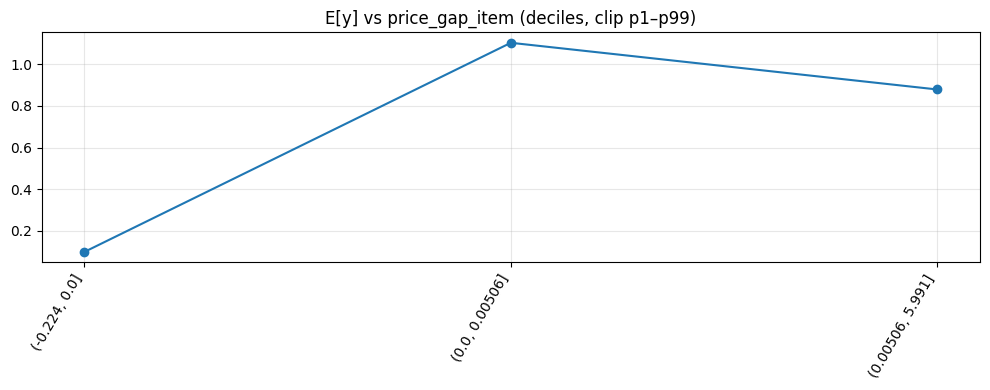

In [24]:
# recorta extremos para visualizar
x = df["price_gap_item"].clip(df["price_gap_item"].quantile(0.01), df["price_gap_item"].quantile(0.99))
bins = pd.qcut(x, 10, duplicates="drop")

g = df.groupby(bins)[y_col].mean()

plt.figure(figsize=(10,4))
plt.plot(g.index.astype(str), g.values, marker="o")
plt.title("E[y] vs price_gap_item (deciles, clip p1–p99)")
plt.xticks(rotation=60, ha="right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [25]:
import numpy as np

# Si tu target se llama y:
y_col = "y"  # cambia a "item_cnt_month" si aplica

df = train_out.copy()  # o el dataframe que estés usando para train
df = df.sort_values(["shop_id","item_id","date_block_num"]).copy()

g = df.groupby(["shop_id","item_id"], sort=False)

# vendió este mes
df["sold_now"] = (df[y_col] > 0).astype(np.int8)

# acumulado HASTA EL MES ANTERIOR (shift(1) evita leakage)
df["sold_cum_lag1"] = g["sold_now"].cumsum().shift(1).fillna(0).astype(np.int16)

# nunca vendió antes (hasta t-1)
df["never_sold_before"] = (df["sold_cum_lag1"] == 0).astype(np.int8)

# sanity check rápido
print(df.groupby("never_sold_before")[y_col].agg(["mean","count"]))


                       mean    count
never_sold_before                   
0                  0.634301  1685106
1                  0.045258  5383494


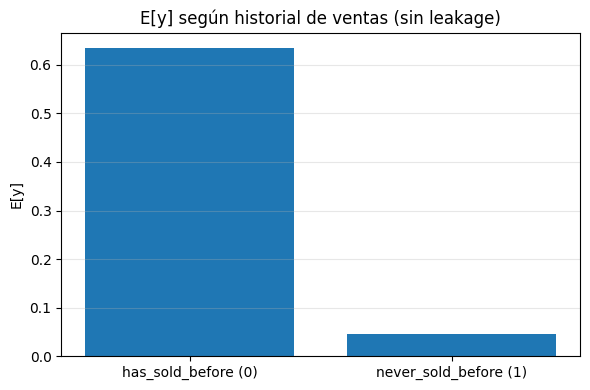

In [26]:
import matplotlib.pyplot as plt

grp = df.groupby("never_sold_before")[y_col].mean()

plt.figure(figsize=(6,4))
plt.bar(["has_sold_before (0)", "never_sold_before (1)"], [grp.get(0,0), grp.get(1,0)])
plt.title("E[y] según historial de ventas (sin leakage)")
plt.ylabel("E[y]")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


### MODELACIÓN

In [27]:
import json
import numpy as np
import pandas as pd
import lightgbm as lgb

OUT_DIR = "intermediate_data"

train_df = pd.read_parquet(f"{OUT_DIR}/train.parquet")
valid_df = pd.read_parquet(f"{OUT_DIR}/valid.parquet")
test_X   = pd.read_parquet(f"{OUT_DIR}/test_features.parquet")

with open(f"{OUT_DIR}/meta.json") as f:
    meta = json.load(f)

feature_cols = meta["feature_cols"]

X_train = train_df[feature_cols]
y_train = train_df["y"].astype("float32")

X_valid = valid_df[feature_cols]
y_valid = valid_df["y"].astype("float32")

X_test  = test_X[feature_cols]

# Categóricas (IDs/mes/año)
cat_features = [c for c in ["shop_id","item_id","month","year"] if c in feature_cols]

# =========================
# 1) Etapa 1: Clasificación (y>0)
# =========================
y_train_bin = (y_train > 0).astype(int)
y_valid_bin = (y_valid > 0).astype(int)

clf = lgb.LGBMClassifier(
    n_estimators=6000,
    learning_rate=0.03,
    num_leaves=256,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
)

clf.fit(
    X_train, y_train_bin,
    eval_set=[(X_valid, y_valid_bin)],
    eval_metric="binary_logloss",
    categorical_feature=cat_features,
    callbacks=[lgb.early_stopping(200, verbose=True)]
)

p_valid = clf.predict_proba(X_valid)[:, 1].astype(np.float32)
p_test  = clf.predict_proba(X_test)[:, 1].astype(np.float32)

# =========================
# 2) Etapa 2: Regresión SOLO donde y>0
# =========================
mask_pos_tr = y_train > 0
mask_pos_va = y_valid > 0

reg = lgb.LGBMRegressor(
    n_estimators=8000,
    learning_rate=0.03,
    num_leaves=256,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    objective="regression"  # (alternativa a probar: "poisson")
)

reg.fit(
    X_train.loc[mask_pos_tr], y_train.loc[mask_pos_tr],
    eval_set=[(X_valid.loc[mask_pos_va], y_valid.loc[mask_pos_va])],
    eval_metric="rmse",
    categorical_feature=cat_features,
    callbacks=[lgb.early_stopping(200, verbose=True)]
)

mu_valid = reg.predict(X_valid).astype(np.float32)
mu_test  = reg.predict(X_test).astype(np.float32)

# =========================
# 3) Combinar (hurdle)
# =========================
pred_valid = (p_valid * mu_valid).clip(0, 20)
pred_test  = (p_test  * mu_test ).clip(0, 20)

rmse = np.sqrt(np.mean((pred_valid - y_valid.values)**2))
print("RMSE valid (hurdle):", rmse)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 570367, number of negative: 6498233
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.868466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8399
[LightGBM] [Info] Number of data points in the train set: 7068600, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080690 -> initscore=-2.433006
[LightGBM] [Info] Start training from score -2.433006
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.307978
[LightGBM] [Warning] Categorical features with more bins than the con

In [28]:
pred_map = pd.DataFrame({
    "shop_id": test_df["shop_id"].values,   # <- tu dataframe de features para test (mes 34)
    "item_id": test_df["item_id"].values,
    "item_cnt_month": pred_test.astype(np.float32)
})

# 3) Merge y clip
sub = test.merge(pred_map, on=["shop_id","item_id"], how="left")
sub["item_cnt_month"] = sub["item_cnt_month"].fillna(0).clip(0, 20)

# 4) Guardar submission
submission = sub[["ID","item_cnt_month"]]
submission.to_csv("submission.csv", index=False)

print("Guardado: submission.csv")
print(submission.head())

Guardado: submission.csv
   ID  item_cnt_month
0   0        0.662606
1   1        0.029288
2   2        1.027942
3   3        0.273108
4   4        0.029288


             decile        n  pred_mean  true_mean       mae      rmse  \
0  (0.0142, 0.0244]  21574.0   0.022269   0.057106  0.078076  0.580244   
1  (0.0244, 0.0273]  22078.0   0.025749   0.075097  0.099104  0.707494   
2  (0.0273, 0.0311]  20608.0   0.028939   0.091178  0.117940  0.825502   
3  (0.0311, 0.0385]  21420.0   0.034646   0.098319  0.130168  0.854240   
4   (0.0385, 0.057]  21420.0   0.046528   0.068301  0.110572  0.529121   
5    (0.057, 0.085]  21420.0   0.069891   0.157376  0.216315  1.039503   
6    (0.085, 0.135]  21420.0   0.107381   0.149020  0.233334  0.723695   
7    (0.135, 0.221]  21420.0   0.173948   0.180252  0.299392  0.478103   
8    (0.221, 0.428]  21420.0   0.303777   0.332726  0.472400  0.665625   
9   (0.428, 15.539]  21420.0   1.208371   1.347852  1.079449  1.728154   

   p_sold_true  
0     0.029804  
1     0.033789  
2     0.037607  
3     0.040196  
4     0.044865  
5     0.077218  
6     0.106069  
7     0.154528  
8     0.261111  
9     0.551401 

/tmp/ipython-input-2811826787.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rep = df.groupby("decile").apply(
/tmp/ipython-input-2811826787.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rep = df.groupby("decile").apply(


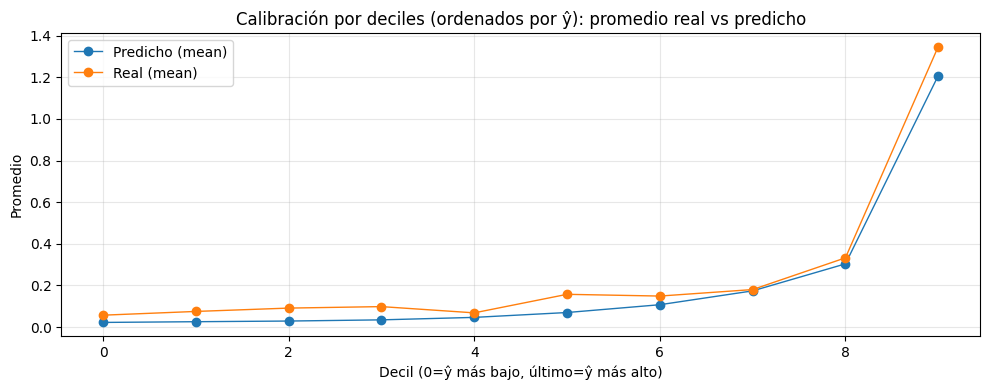

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def decile_report(y_true, y_pred, n_bins=10, clip=(0,20)):
    y_true = np.asarray(y_true).astype(float)
    y_pred = np.asarray(y_pred).astype(float)

    if clip is not None:
        y_pred = np.clip(y_pred, clip[0], clip[1])

    df = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    # deciles por predicción (si hay muchos empates, qcut puede bajar bins; por eso duplicates="drop")
    df["decile"] = pd.qcut(df["y_pred"], q=n_bins, duplicates="drop")

    rep = df.groupby("decile").apply(
        lambda g: pd.Series({
            "n": len(g),
            "pred_mean": g["y_pred"].mean(),
            "true_mean": g["y_true"].mean(),
            "pred_median": g["y_pred"].median(),
            "true_median": g["y_true"].median(),
            "mae": np.mean(np.abs(g["y_true"] - g["y_pred"])),
            "rmse": np.sqrt(np.mean((g["y_true"] - g["y_pred"])**2)),
            "p_sold_true": np.mean(g["y_true"] > 0),
        })
    ).reset_index()

    return rep, df

rep, df_dec = decile_report(y_valid, pred_valid, n_bins=10, clip=(0,20))
print(rep[["decile","n","pred_mean","true_mean","mae","rmse","p_sold_true"]])

# Plot: promedio por decil
x = np.arange(len(rep))

plt.figure(figsize=(10,4))
plt.plot(x, rep["pred_mean"], marker="o", linewidth=1, label="Predicho (mean)")
plt.plot(x, rep["true_mean"], marker="o", linewidth=1, label="Real (mean)")
plt.title("Calibración por deciles (ordenados por ŷ): promedio real vs predicho")
plt.xlabel("Decil (0=ŷ más bajo, último=ŷ más alto)")
plt.ylabel("Promedio")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
dfv = pd.DataFrame({"y": y_valid, "yhat": pred_valid}).copy()

for thr in [5, 10, 15]:
    sub = dfv[dfv["y"] >= thr]
    rmse = np.sqrt(np.mean((sub["y"] - sub["yhat"])**2))
    mae  = np.mean(np.abs(sub["y"] - sub["yhat"]))
    print(f"y>={thr}: n={len(sub)}  mean(y)={sub['y'].mean():.2f}  mean(yhat)={sub['yhat'].mean():.2f}  MAE={mae:.2f}  RMSE={rmse:.2f}")


y>=5: n=1847  mean(y)=9.15  mean(yhat)=2.97  MAE=6.32  RMSE=7.90
y>=10: n=581  mean(y)=15.48  mean(yhat)=4.57  MAE=10.93  RMSE=12.29
y>=15: n=312  mean(y)=18.72  mean(yhat)=5.15  MAE=13.57  RMSE=14.71


In [31]:
dfv["y_dec"] = pd.qcut(dfv["y"], 10, duplicates="drop")
rep = dfv.groupby("y_dec").agg(
    n=("y","size"),
    y_mean=("y","mean"),
    yhat_mean=("yhat","mean"),
    rmse=("y", lambda s: np.sqrt(np.mean((s - dfv.loc[s.index, "yhat"])**2)))
).reset_index()

print(rep[["y_dec","n","y_mean","yhat_mean","rmse"]])


           y_dec       n    y_mean  yhat_mean      rmse
0  (-0.001, 1.0]  204838  0.094045   0.148886  0.346168
1    (1.0, 20.0]    9362  3.791497   1.367224  3.896786


/tmp/ipython-input-2887517200.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rep = dfv.groupby("y_dec").agg(


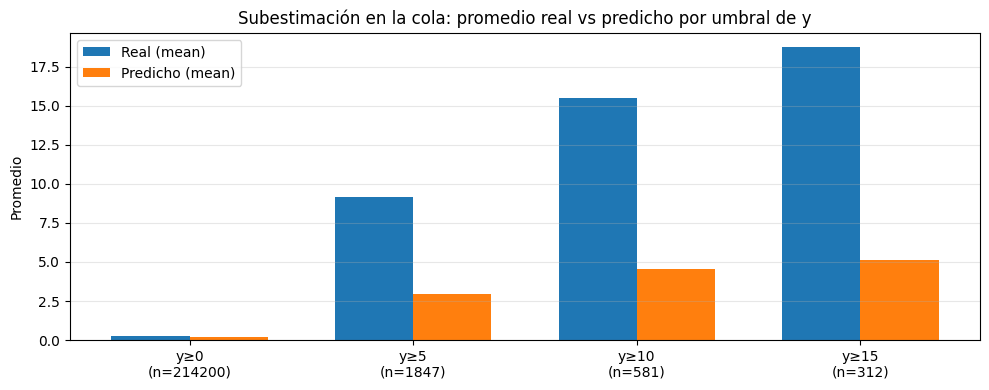

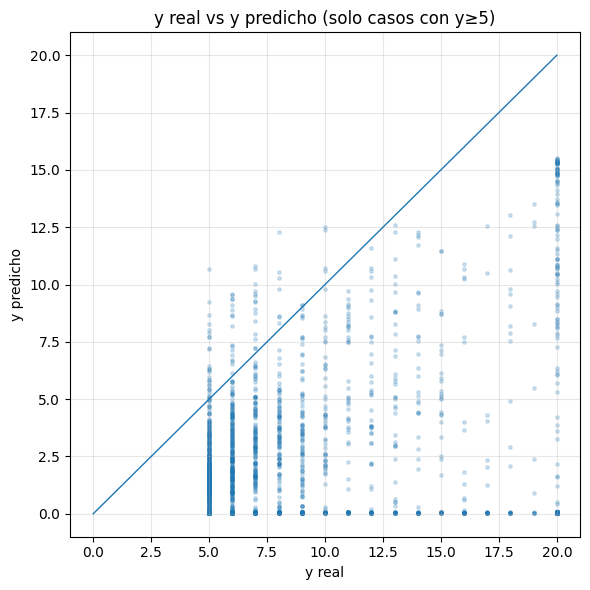

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dfv = pd.DataFrame({"y": y_valid, "yhat": pred_valid}).copy()
dfv = dfv.replace([np.inf, -np.inf], np.nan).dropna()

# 1) Barras: promedio real vs predicho para umbrales
thresholds = [0, 5, 10, 15]
rows = []
for thr in thresholds:
    sub = dfv[dfv["y"] >= thr]
    rows.append({
        "thr": thr,
        "n": len(sub),
        "mean_y": sub["y"].mean(),
        "mean_yhat": sub["yhat"].mean(),
        "rmse": np.sqrt(np.mean((sub["y"] - sub["yhat"])**2)),
        "mae": np.mean(np.abs(sub["y"] - sub["yhat"])),
    })
rep_thr = pd.DataFrame(rows)

x = np.arange(len(rep_thr))
w = 0.35

plt.figure(figsize=(10,4))
plt.bar(x - w/2, rep_thr["mean_y"], width=w, label="Real (mean)")
plt.bar(x + w/2, rep_thr["mean_yhat"], width=w, label="Predicho (mean)")
plt.title("Subestimación en la cola: promedio real vs predicho por umbral de y")
plt.xticks(x, [f"y≥{t}\n(n={n})" for t,n in zip(rep_thr["thr"], rep_thr["n"])])
plt.ylabel("Promedio")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Scatter (zoom): y vs yhat para y>=5
sub = dfv[dfv["y"] >= 5].copy()

plt.figure(figsize=(6,6))
plt.scatter(sub["y"], sub["yhat"], s=6, alpha=0.2)
mx = max(sub["y"].max(), sub["yhat"].max(), 20)
plt.plot([0,mx],[0,mx], linewidth=1)  # línea perfecta
plt.title("y real vs y predicho (solo casos con y≥5)")
plt.xlabel("y real")
plt.ylabel("y predicho")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [33]:
print('print hola mundo')

print hola mundo


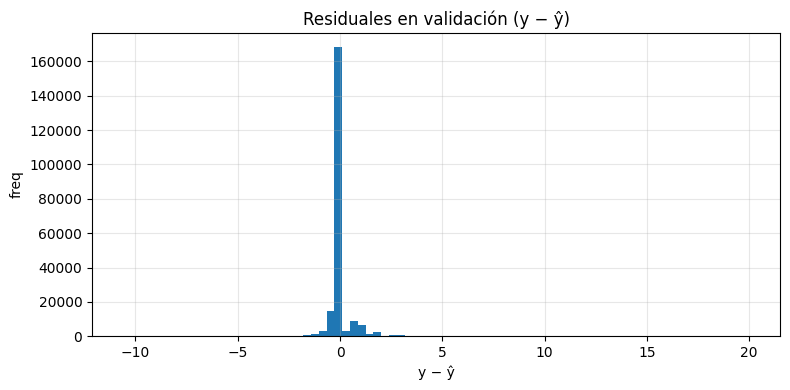

Bias (mean residual): 0.05351366847753525
MAE: 0.2835887670516968
RMSE: 0.8822017908096313


In [34]:


res = y_valid - pred_valid

plt.figure(figsize=(8,4))
plt.hist(res, bins=80)
plt.title("Residuales en validación (y − ŷ)")
plt.xlabel("y − ŷ")
plt.ylabel("freq")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Bias (mean residual):", float(np.mean(res)))
print("MAE:", float(np.mean(np.abs(res))))
print("RMSE:", float(np.sqrt(np.mean(res**2))))


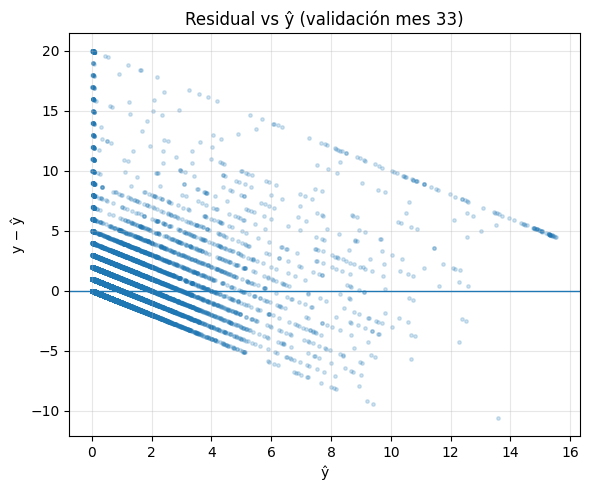

In [35]:
plt.figure(figsize=(6,5))
plt.scatter(pred_valid, (y_valid - pred_valid), s=6, alpha=0.2)
plt.axhline(0, linewidth=1)
plt.title("Residual vs ŷ (validación mes 33)")
plt.xlabel("ŷ")
plt.ylabel("y − ŷ")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


/tmp/ipython-input-3575680699.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rep = dfv.groupby("rec_bin").apply(lambda g: pd.Series({
/tmp/ipython-input-3575680699.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rep = dfv.groupby("rec_bin").apply(lambda g: pd.Series({


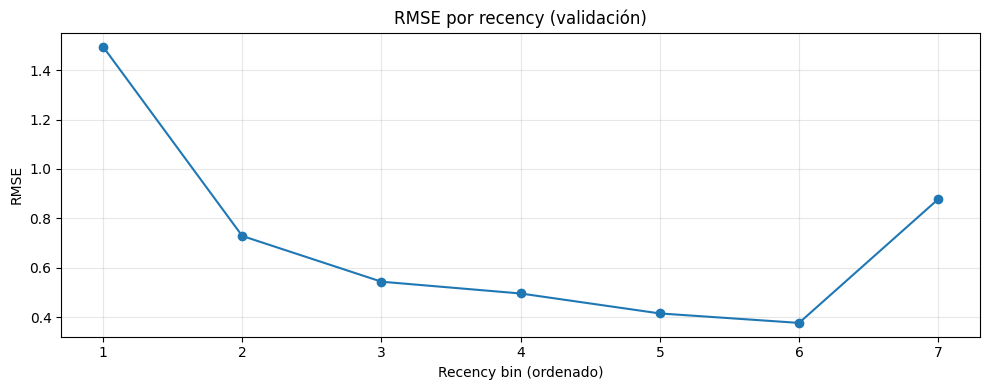

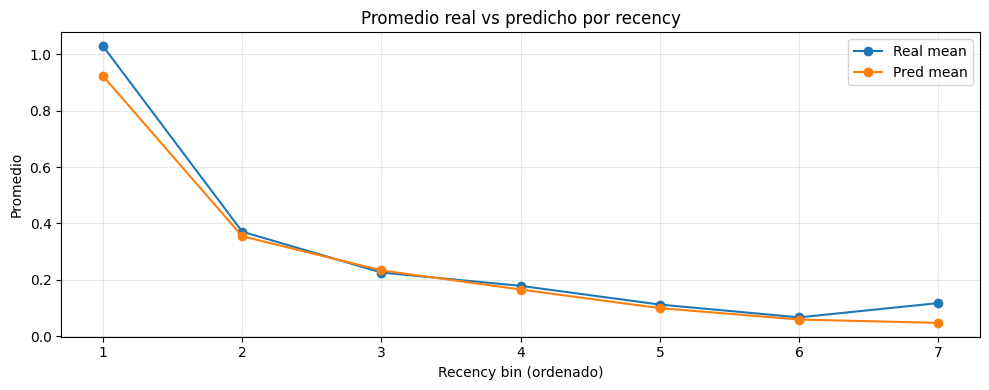

In [36]:

dfv = pd.DataFrame({
    "recency": X_valid["recency"],
    "y": y_valid,
    "yhat": pred_valid
})

dfv["rec_bin"] = pd.cut(dfv["recency"], bins=[-1,0,1,2,3,6,12,24,99])
rep = dfv.groupby("rec_bin").apply(lambda g: pd.Series({
    "n": len(g),
    "rmse": np.sqrt(np.mean((g["y"]-g["yhat"])**2)),
    "mean_y": g["y"].mean(),
    "mean_yhat": g["yhat"].mean(),
    "p_sold": np.mean(g["y"]>0)
})).reset_index()

x = np.arange(len(rep))
plt.figure(figsize=(10,4))
plt.plot(x, rep["rmse"], marker="o")
plt.title("RMSE por recency (validación)")
plt.xlabel("Recency bin (ordenado)")
plt.ylabel("RMSE")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(x, rep["mean_y"], marker="o", label="Real mean")
plt.plot(x, rep["mean_yhat"], marker="o", label="Pred mean")
plt.title("Promedio real vs predicho por recency")
plt.xlabel("Recency bin (ordenado)")
plt.ylabel("Promedio")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [37]:
print("unique months:", sorted(pd.Series(X_valid["month"]).unique()))
print("n unique:", pd.Series(X_valid["month"]).nunique())
print("date_block_num unique:", pd.Series(X_valid["date_block_num"]).unique()[:10], " ... nunique=", pd.Series(X_valid["date_block_num"]).nunique())


unique months: [np.int8(9)]
n unique: 1
date_block_num unique: [33]  ... nunique= 1


/tmp/ipython-input-3810999357.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rep = dfv.groupby("rate_bin").apply(lambda g: pd.Series({
/tmp/ipython-input-3810999357.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rep = dfv.groupby("rate_bin").apply(lambda g: pd.Series({


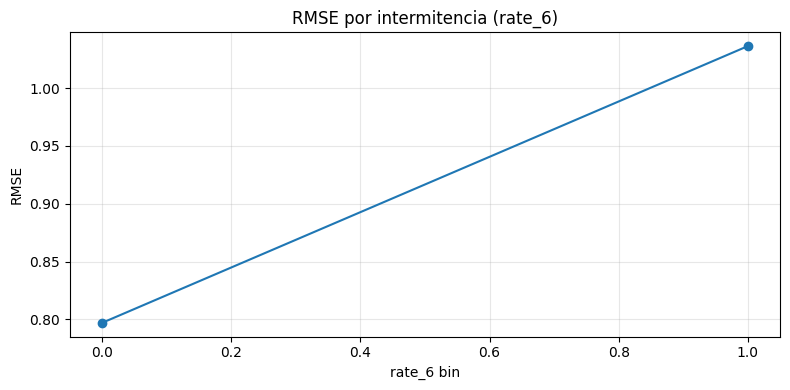

In [38]:
dfv = pd.DataFrame({
    "rate_6": X_valid["rate_6"],
    "y": y_valid,
    "yhat": pred_valid
})
dfv["rate_bin"] = pd.cut(dfv["rate_6"], bins=[-0.001, 0.001, 0.2, 0.5, 1.0])

rep = dfv.groupby("rate_bin").apply(lambda g: pd.Series({
    "n": len(g),
    "rmse": np.sqrt(np.mean((g["y"]-g["yhat"])**2)),
    "mean_y": g["y"].mean(),
    "mean_yhat": g["yhat"].mean(),
    "p_sold": np.mean(g["y"]>0)
})).reset_index()

x = np.arange(len(rep))
plt.figure(figsize=(8,4))
plt.plot(x, rep["rmse"], marker="o")
plt.title("RMSE por intermitencia (rate_6)")
plt.xlabel("rate_6 bin")
plt.ylabel("RMSE")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


/tmp/ipython-input-3964677508.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_bias = dfv.pivot_table(values="y", index="rec_b", columns="rate_b",


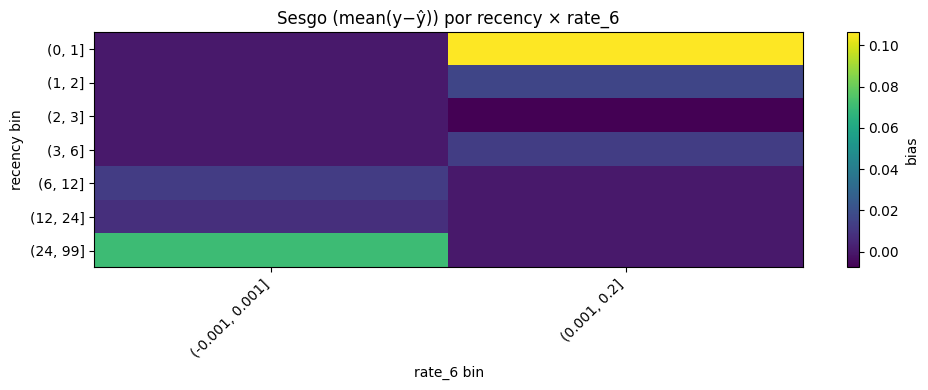

In [39]:
dfv = pd.DataFrame({
    "recency": X_valid["recency"],
    "rate_6": X_valid["rate_6"],
    "y": y_valid,
    "yhat": pred_valid
})
dfv["rec_b"] = pd.cut(dfv["recency"], bins=[-1,0,1,2,3,6,12,24,99])
dfv["rate_b"] = pd.cut(dfv["rate_6"], bins=[-0.001, 0.001, 0.2, 0.5, 1.0])

pivot_bias = dfv.pivot_table(values="y", index="rec_b", columns="rate_b",
                             aggfunc=lambda s: np.mean(s - dfv.loc[s.index,"yhat"])).fillna(0)

plt.figure(figsize=(10,4))
plt.imshow(pivot_bias.values, aspect="auto")
plt.title("Sesgo (mean(y−ŷ)) por recency × rate_6")
plt.xlabel("rate_6 bin")
plt.ylabel("recency bin")
plt.xticks(range(len(pivot_bias.columns)), [str(c) for c in pivot_bias.columns], rotation=45, ha="right")
plt.yticks(range(len(pivot_bias.index)), [str(i) for i in pivot_bias.index])
plt.colorbar(label="bias")
plt.tight_layout()
plt.show()


In [40]:
dfv = X_valid.copy()
dfv["y"] = y_valid
dfv["yhat"] = pred_valid
dfv["abs_err"] = np.abs(dfv["y"] - dfv["yhat"])

cols_show = ["shop_id","item_id","recency","rate_6","cnt_lag_1","cnt_lag_12","y","yhat","abs_err"]
display(dfv.sort_values("abs_err", ascending=False)[cols_show].head(20))


,shop_id,item_id,recency,rate_6,cnt_lag_1,cnt_lag_12,y,yhat,abs_err
132518,39,21811,18,0.0,0.0,0.0,20.0,0.021483,19.978518
104295,34,10201,99,0.0,0.0,0.0,20.0,0.021934,19.978065
129795,39,10201,99,0.0,0.0,0.0,20.0,0.023460,19.976540
165496,48,10202,99,0.0,0.0,0.0,20.0,0.024351,19.975649
165495,48,10201,99,0.0,0.0,0.0,20.0,0.024351,19.975649
150195,45,10201,99,0.0,0.0,0.0,20.0,0.025032,19.974968
150196,45,10202,99,0.0,0.0,0.0,20.0,0.025032,19.974968
211395,59,10201,99,0.0,0.0,0.0,20.0,0.025262,19.974737
131494,39,16629,99,0.0,0.0,0.0,20.0,0.026629,19.973372
2296,2,10202,99,0.0,0.0,0.0,20.0,0.027084,19.972916


In [41]:
import joblib

bundle = {
    "clf": clf,
    "reg": reg,
    "feature_cols": feature_cols,
    "cat_features": cat_features,
    "meta": meta  # opcional, pero útil
}

joblib.dump(bundle, "model_tarea1.pkl")
print("Guardado: model_tarea1.pkl")


Guardado: model_tarea1.pkl


In [42]:
import numpy as np
import pandas as pd
import joblib
from math import sqrt

OUT_DIR = "intermediate_data"

# Carga base de validación (mes 33)
valid = pd.read_parquet(f"{OUT_DIR}/valid.parquet")

# Carga modelo hurdle
bundle = joblib.load("model_tarea1.pkl")
clf = bundle["clf"]
reg = bundle["reg"]
feature_cols = bundle["feature_cols"]

X_valid = valid[feature_cols]
y_true = valid["y"].astype(np.float32).values

# Predicción del modelo (hurdle)
p = clf.predict_proba(X_valid)[:, 1].astype(np.float32)
mu = reg.predict(X_valid).astype(np.float32)
yhat_model = np.clip(p * mu, 0, 20)

# Baseline: forecast = lag1 (si existe)
if "cnt_lag_1" in valid.columns:
    yhat_lag1 = np.clip(valid["cnt_lag_1"].astype(np.float32).values, 0, 20)
else:
    raise ValueError("No encuentro cnt_lag_1 en valid.parquet para baseline.")

# Parámetros de inventario (ajustables)
service_level = 0.95
z_map = {0.90: 1.2816, 0.95: 1.6449, 0.97: 1.8808, 0.99: 2.3263}
z = z_map.get(service_level, 1.6449)

holding_cost_per_unit = 1.0      # costo de mantener 1 unidad al fin de mes
stockout_cost_per_unit = 4.0     # penalización por unidad no satisfecha (proxy de margen/NPS)

# Inventario inicial al inicio del mes: aproximación (lo típico: venías con stock ~ demanda del mes anterior)
# Usamos lag1 como "stock planeado" (puedes cambiarlo por otra regla)
on_hand0 = yhat_lag1.copy()

def simulate_policy(y_true, y_forecast, on_hand0, z, sigma,
                    h=1.0, p=4.0):
    """
    Política order-up-to:
    target = forecast + z*sigma
    order = max(0, target - on_hand)
    sales = min(on_hand + order, demand)
    end_inventory = on_hand + order - sales
    lost_sales = demand - sales
    """
    target = np.clip(y_forecast + z * sigma, 0, 20)  # coherente con clipping del problema
    order_qty = np.maximum(0.0, target - on_hand0)

    available = on_hand0 + order_qty
    sales = np.minimum(available, y_true)

    end_inv = available - sales
    lost = y_true - sales

    holding_cost = h * end_inv
    stockout_cost = p * lost

    return {
        "target": target,
        "order_qty": order_qty,
        "sales": sales,
        "end_inv": end_inv,
        "lost": lost,
        "holding_cost": holding_cost,
        "stockout_cost": stockout_cost,
        "total_cost": holding_cost + stockout_cost,
        "fill_rate": sales.sum() / (y_true.sum() + 1e-9),
        "service_level": np.mean(lost == 0),  # % de pares sin quiebre
    }

# Estima sigma del error (en unidades)
sigma_model = float(np.std(y_true - yhat_model))
sigma_lag1  = float(np.std(y_true - yhat_lag1))

sim_model = simulate_policy(y_true, yhat_model, on_hand0, z, sigma_model,
                            h=holding_cost_per_unit, p=stockout_cost_per_unit)

sim_lag1  = simulate_policy(y_true, yhat_lag1, on_hand0, z, sigma_lag1,
                            h=holding_cost_per_unit, p=stockout_cost_per_unit)

summary = pd.DataFrame([
    {
        "policy": "model_hurdle",
        "fill_rate": sim_model["fill_rate"],
        "service_level": sim_model["service_level"],
        "lost_units": sim_model["lost"].sum(),
        "ending_inventory": sim_model["end_inv"].sum(),
        "total_cost": sim_model["total_cost"].sum(),
        "holding_cost": sim_model["holding_cost"].sum(),
        "stockout_cost": sim_model["stockout_cost"].sum(),
        "sigma_used": sigma_model,
    },
    {
        "policy": "baseline_lag1",
        "fill_rate": sim_lag1["fill_rate"],
        "service_level": sim_lag1["service_level"],
        "lost_units": sim_lag1["lost"].sum(),
        "ending_inventory": sim_lag1["end_inv"].sum(),
        "total_cost": sim_lag1["total_cost"].sum(),
        "holding_cost": sim_lag1["holding_cost"].sum(),
        "stockout_cost": sim_lag1["stockout_cost"].sum(),
        "sigma_used": sigma_lag1,
    }
])

print(summary)


          policy  fill_rate  service_level    lost_units  ending_inventory  \
0   model_hurdle   0.806535       0.973768  10594.141602       317349.1875   
1  baseline_lag1   0.835151       0.975504   9027.125000       388655.5000   

    total_cost  holding_cost  stockout_cost  sigma_used  
0  359725.8125   317349.1875   42376.566406    0.880577  
1  424764.0000   388655.5000   36108.500000    1.084243  


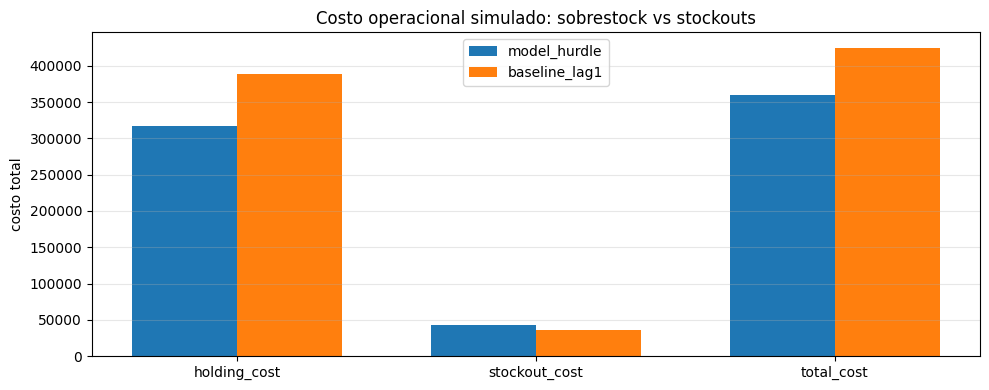

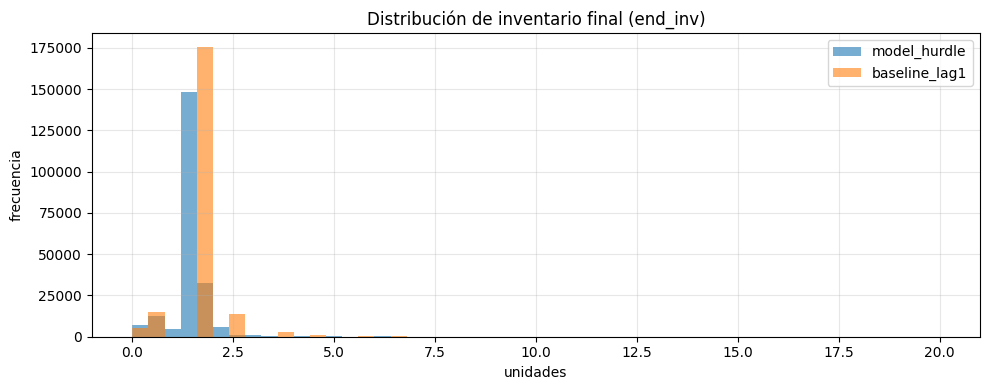

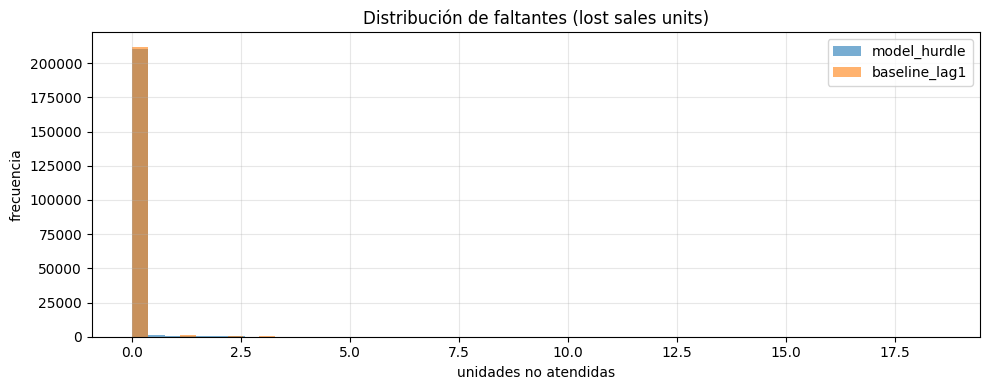

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Comparación de costos
labels = ["holding_cost", "stockout_cost", "total_cost"]
x = np.arange(len(labels))
w = 0.35

plt.figure(figsize=(10,4))
plt.bar(x - w/2, [sim_model[k].sum() for k in labels], width=w, label="model_hurdle")
plt.bar(x + w/2, [sim_lag1[k].sum() for k in labels], width=w, label="baseline_lag1")
plt.xticks(x, labels)
plt.title("Costo operacional simulado: sobrestock vs stockouts")
plt.ylabel("costo total")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Distribución de inventario final (sobrestock proxy)
plt.figure(figsize=(10,4))
plt.hist(sim_model["end_inv"], bins=50, alpha=0.6, label="model_hurdle")
plt.hist(sim_lag1["end_inv"], bins=50, alpha=0.6, label="baseline_lag1")
plt.title("Distribución de inventario final (end_inv)")
plt.xlabel("unidades")
plt.ylabel("frecuencia")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 3) Distribución de faltantes (stockouts)
plt.figure(figsize=(10,4))
plt.hist(sim_model["lost"], bins=50, alpha=0.6, label="model_hurdle")
plt.hist(sim_lag1["lost"], bins=50, alpha=0.6, label="baseline_lag1")
plt.title("Distribución de faltantes (lost sales units)")
plt.xlabel("unidades no atendidas")
plt.ylabel("frecuencia")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [44]:
print("model lost_units:", sim_model["lost"].sum(), "fill_rate:", sim_model["fill_rate"], "service:", sim_model["service_level"])
print("lag1  lost_units:", sim_lag1["lost"].sum(),  "fill_rate:", sim_lag1["fill_rate"],  "service:", sim_lag1["service_level"])
print("model stockout_cost:", sim_model["stockout_cost"].sum(), "lag1 stockout_cost:", sim_lag1["stockout_cost"].sum())


model lost_units: 10594.142 fill_rate: 0.806535 service: 0.9737675070028011
lag1  lost_units: 9027.125 fill_rate: 0.8351512 service: 0.9755042016806723
model stockout_cost: 42376.566 lag1 stockout_cost: 36108.5


In [45]:
mask_hi = y_true >= 5
print("lost_units (y>=5) model:", sim_model["lost"][mask_hi].sum(), "lag1:", sim_lag1["lost"][mask_hi].sum())


lost_units (y>=5) model: 7592.1426 lag1: 6821.33


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate_policy(y_true, y_forecast, on_hand0, z, sigma, h=1.0, p=4.0):
    target = np.clip(y_forecast + z * sigma, 0, 20)
    order_qty = np.maximum(0.0, target - on_hand0)

    available = on_hand0 + order_qty
    sales = np.minimum(available, y_true)

    end_inv = available - sales
    lost = y_true - sales

    holding_cost = h * end_inv
    stockout_cost = p * lost

    return {
        "end_inv": end_inv,
        "lost": lost,
        "holding_cost": holding_cost.sum(),
        "stockout_cost": stockout_cost.sum(),
        "total_cost": (holding_cost + stockout_cost).sum(),
        "fill_rate": sales.sum() / (y_true.sum() + 1e-9),
        "service_level": np.mean(lost == 0),
        "lost_units": lost.sum(),
    }

# Rango de penalizaciones por stockout (ajusta a gusto)
stockout_cost_grid = [0, 1, 2, 4, 6, 8, 10, 15, 20, 30, 40, 50]

rows = []
for p_cost in stockout_cost_grid:
    sim_m = simulate_policy(y_true, yhat_model, on_hand0, z, sigma_model, h=holding_cost_per_unit, p=p_cost)
    sim_b = simulate_policy(y_true, yhat_lag1,  on_hand0, z, sigma_lag1,  h=holding_cost_per_unit, p=p_cost)

    rows.append({
        "stockout_cost_per_unit": p_cost,
        "total_cost_model": sim_m["total_cost"],
        "total_cost_lag1": sim_b["total_cost"],
        "delta_model_minus_lag1": sim_m["total_cost"] - sim_b["total_cost"],
        "holding_model": sim_m["holding_cost"],
        "holding_lag1": sim_b["holding_cost"],
        "stockout_model": sim_m["stockout_cost"],
        "stockout_lag1": sim_b["stockout_cost"],
        "lost_units_model": sim_m["lost_units"],
        "lost_units_lag1": sim_b["lost_units"],
        "fill_rate_model": sim_m["fill_rate"],
        "fill_rate_lag1": sim_b["fill_rate"],
        "service_model": sim_m["service_level"],
        "service_lag1": sim_b["service_level"],
    })

sens = pd.DataFrame(rows)
print(sens[["stockout_cost_per_unit","total_cost_model","total_cost_lag1","delta_model_minus_lag1"]])


    stockout_cost_per_unit  total_cost_model  total_cost_lag1  \
0                        0      317349.18750     388655.50000   
1                        1      327943.40625     397682.65625   
2                        2      338537.56250     406709.71875   
3                        4      359725.81250     424764.00000   
4                        6      380914.06250     442818.31250   
5                        8      402102.43750     460872.53125   
6                       10      423290.65625     478926.71875   
7                       15      476261.43750     524062.37500   
8                       20      529232.12500     569198.00000   
9                       30      635173.62500     659469.31250   
10                      40      741115.00000     749740.43750   
11                      50      847056.43750     840011.68750   

    delta_model_minus_lag1  
0             -71306.31250  
1             -69739.25000  
2             -68172.15625  
3             -65038.18750  
4        

In [47]:
# break-even: cuando delta pasa de negativo a positivo
sens_sorted = sens.sort_values("stockout_cost_per_unit").copy()
sens_sorted["model_better"] = sens_sorted["delta_model_minus_lag1"] < 0

print("Modelo mejor (True/False) por p_cost:")
print(sens_sorted[["stockout_cost_per_unit","model_better","delta_model_minus_lag1"]])

# primer punto donde deja de ser mejor (delta >= 0)
bad = sens_sorted[sens_sorted["delta_model_minus_lag1"] >= 0]
if len(bad) == 0:
    print("El modelo es mejor que lag1 en todo el rango probado.")
else:
    p_break = bad.iloc[0]["stockout_cost_per_unit"]
    print("Break-even aproximado: stockout_cost_per_unit ≈", p_break)


Modelo mejor (True/False) por p_cost:
    stockout_cost_per_unit  model_better  delta_model_minus_lag1
0                        0          True            -71306.31250
1                        1          True            -69739.25000
2                        2          True            -68172.15625
3                        4          True            -65038.18750
4                        6          True            -61904.25000
5                        8          True            -58770.09375
6                       10          True            -55636.06250
7                       15          True            -47800.93750
8                       20          True            -39965.87500
9                       30          True            -24295.68750
10                      40          True             -8625.43750
11                      50         False              7044.75000
Break-even aproximado: stockout_cost_per_unit ≈ 50


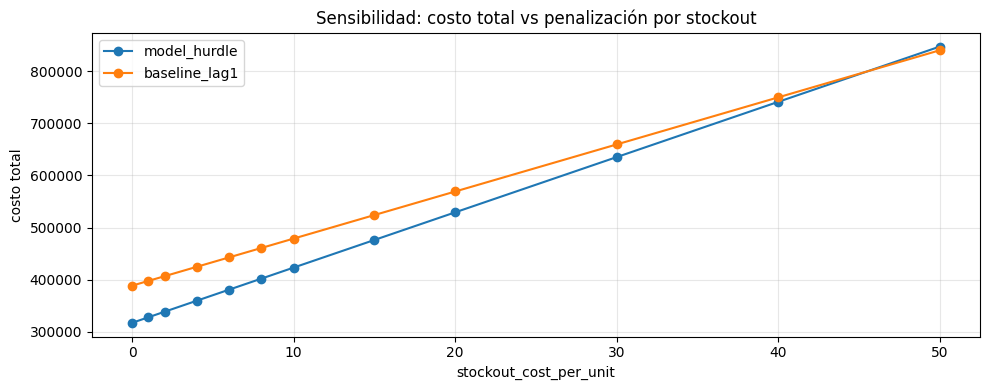

In [48]:
plt.figure(figsize=(10,4))
plt.plot(sens["stockout_cost_per_unit"], sens["total_cost_model"], marker="o", label="model_hurdle")
plt.plot(sens["stockout_cost_per_unit"], sens["total_cost_lag1"], marker="o", label="baseline_lag1")
plt.title("Sensibilidad: costo total vs penalización por stockout")
plt.xlabel("stockout_cost_per_unit")
plt.ylabel("costo total")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [49]:
print('hola mundo')

hola mundo


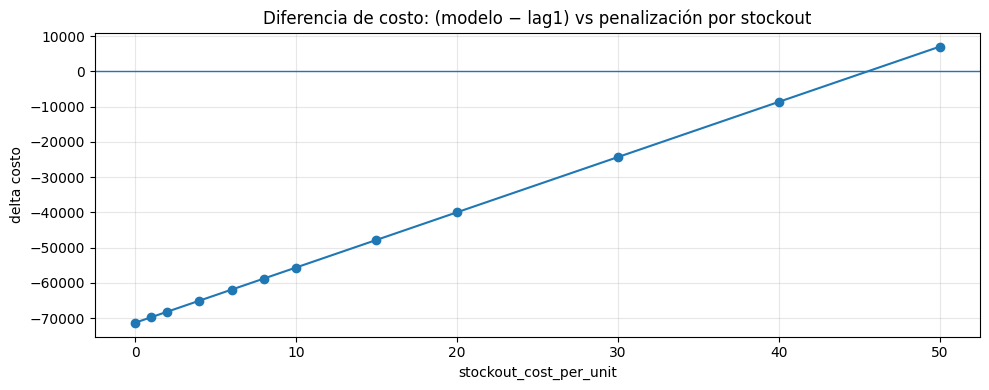

In [50]:
plt.figure(figsize=(10,4))
plt.plot(sens["stockout_cost_per_unit"], sens["delta_model_minus_lag1"], marker="o")
plt.axhline(0, linewidth=1)
plt.title("Diferencia de costo: (modelo − lag1) vs penalización por stockout")
plt.xlabel("stockout_cost_per_unit")
plt.ylabel("delta costo")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


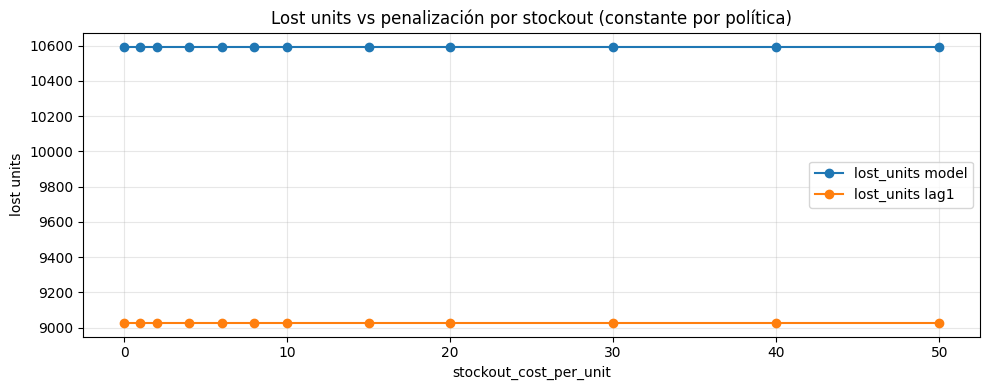

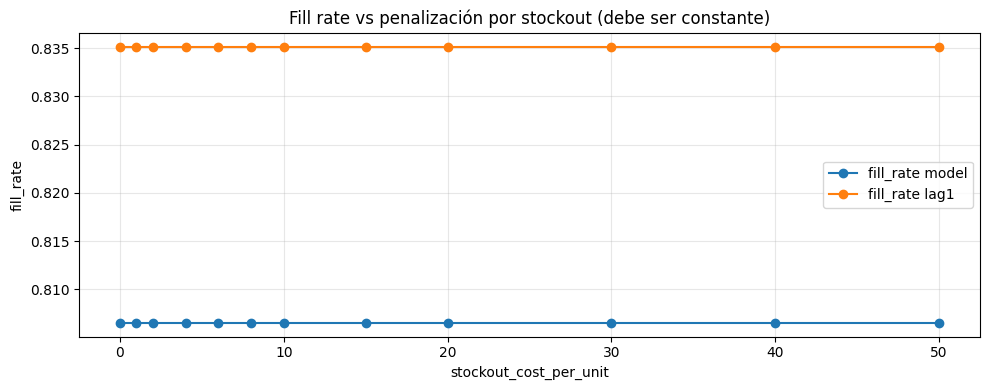

In [51]:
plt.figure(figsize=(10,4))
plt.plot(sens["stockout_cost_per_unit"], sens["lost_units_model"], marker="o", label="lost_units model")
plt.plot(sens["stockout_cost_per_unit"], sens["lost_units_lag1"], marker="o", label="lost_units lag1")
plt.title("Lost units vs penalización por stockout (constante por política)")
plt.xlabel("stockout_cost_per_unit")
plt.ylabel("lost units")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(sens["stockout_cost_per_unit"], sens["fill_rate_model"], marker="o", label="fill_rate model")
plt.plot(sens["stockout_cost_per_unit"], sens["fill_rate_lag1"], marker="o", label="fill_rate lag1")
plt.title("Fill rate vs penalización por stockout (debe ser constante)")
plt.xlabel("stockout_cost_per_unit")
plt.ylabel("fill_rate")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [53]:
import json
import numpy as np
import pandas as pd
import lightgbm as lgb

OUT_DIR = "intermediate_data"

train_df = pd.read_parquet(f"{OUT_DIR}/train.parquet")
valid_df = pd.read_parquet(f"{OUT_DIR}/valid.parquet")
test_df  = pd.read_parquet(f"{OUT_DIR}/test_features.parquet")

with open(f"{OUT_DIR}/meta.json") as f:
    meta = json.load(f)

# Baseline simple: solo tiempo + IDs + lag1 (y opcional lag12)
basic_cols = []
for c in ["date_block_num", "month", "year", "shop_id", "item_id", "cnt_lag_1", "cnt_lag_12"]:
    if c in train_df.columns:
        basic_cols.append(c)

X_train = train_df[basic_cols]
y_train = train_df["y"].astype(np.float32)

X_valid = valid_df[basic_cols]
y_valid = valid_df["y"].astype(np.float32)

X_test = test_df[basic_cols]

cat_features = [c for c in ["shop_id", "item_id", "month", "year"] if c in basic_cols]

baseline_lgbm = lgb.LGBMRegressor(
    n_estimators=4000,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42
)

baseline_lgbm.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="rmse",
    categorical_feature=cat_features,
    callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=True)]
)

pred_valid = np.clip(baseline_lgbm.predict(X_valid).astype(np.float32), 0, 20)
rmse = float(np.sqrt(np.mean((pred_valid - y_valid.values) ** 2)))
print("RMSE valid (baseline_lgbm):", rmse)
print("Best iteration:", baseline_lgbm.best_iteration_)

pred_test = np.clip(baseline_lgbm.predict(X_test).astype(np.float32), 0, 20)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.200434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5157
[LightGBM] [Info] Number of data points in the train set: 7068600, number of used features: 7
[LightGBM] [Info] Start training from score 0.185682
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	valid_0's rmse: 0.900493	valid_0's l2: 0.810887
RMSE valid (baseline_lgbm): 0.9004925489425659
Best iteration: 53


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5157
[LightGBM] [Info] Number of data points in the train set: 7068600, number of used features: 7
[LightGBM] [Info] Start training from score 0.185682
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[53]	valid_0's rmse: 0.900493	valid_0's l2: 0.810887
RMSE valid (baseline_lgbm): 0.9004925489425659
Best iteration baseline: 53
Guardado: baseline_lgbm.pkl
RMSE valid (model_hurdle): 0.8822017908096313
Comparación RMSE (validación)
baseline_lgbm: 0.9004925489425659

/tmp/ipython-input-1173453825.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rep = df.groupby("decile").agg(y_mean=("y","mean"), yhat_mean=("yhat","mean")).reset_index()


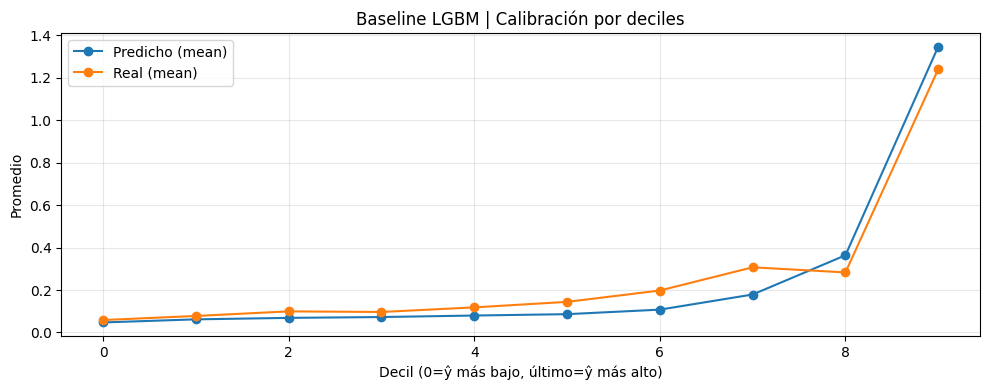

/tmp/ipython-input-1173453825.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rep = df.groupby("decile").agg(y_mean=("y","mean"), yhat_mean=("yhat","mean")).reset_index()


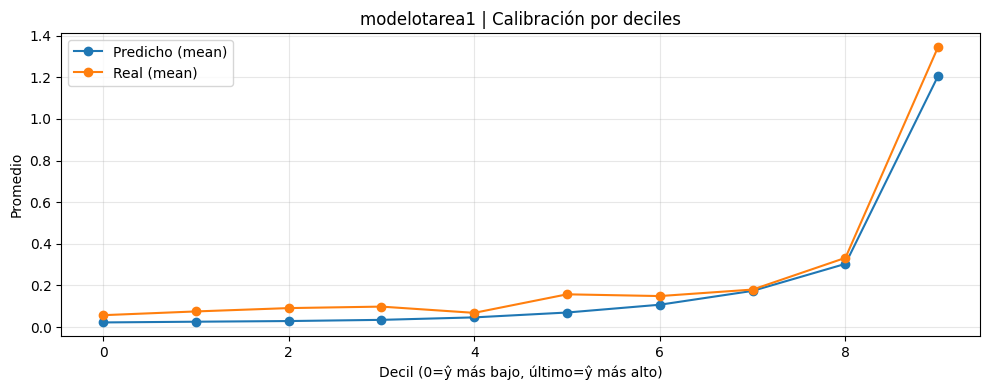

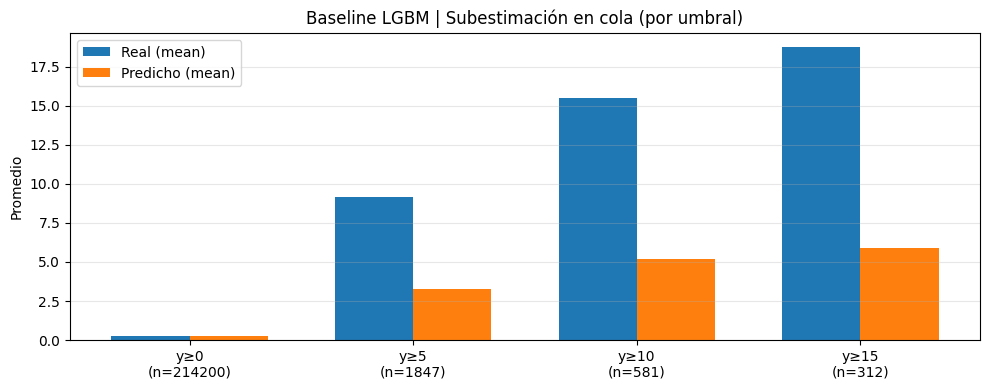

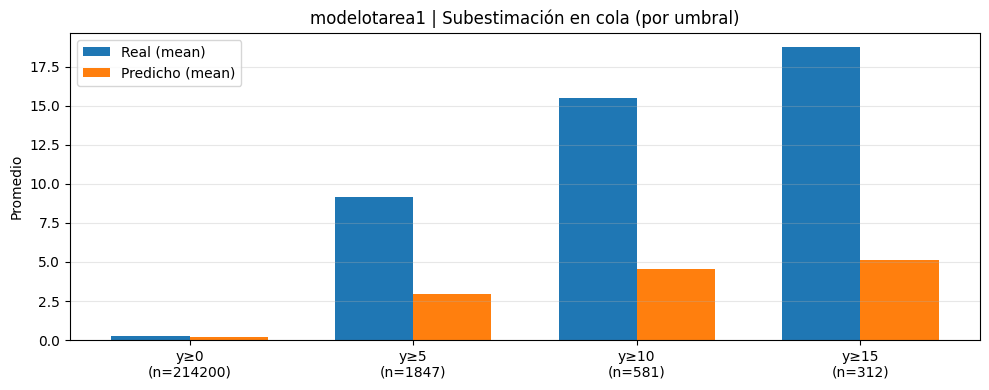

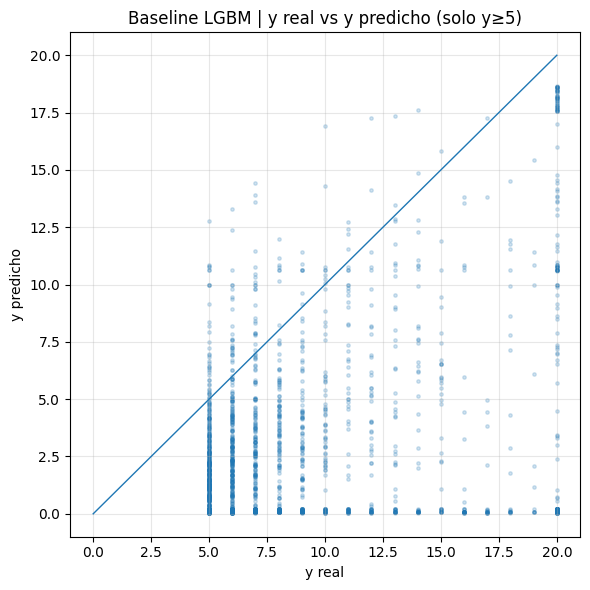

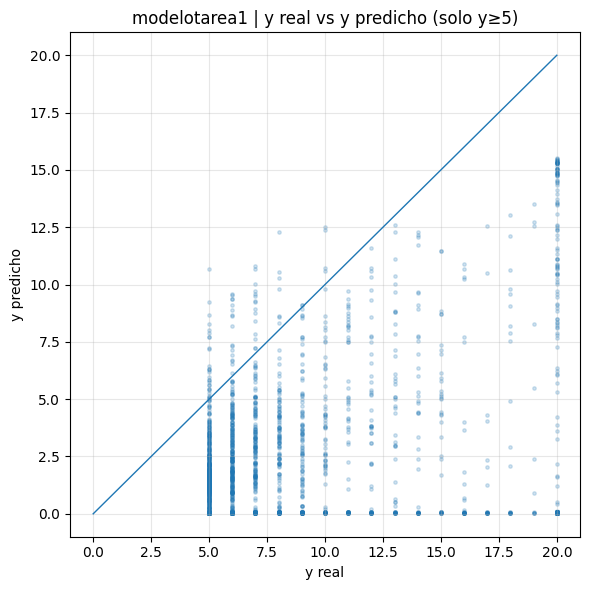

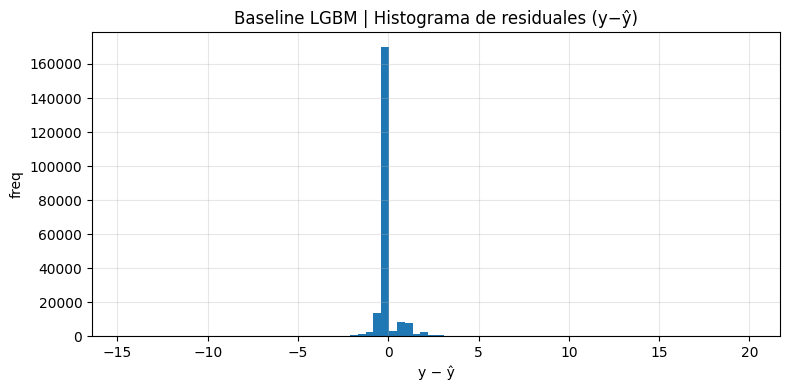

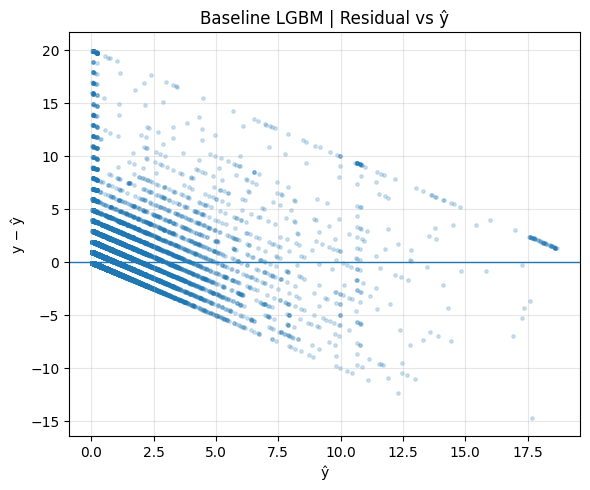

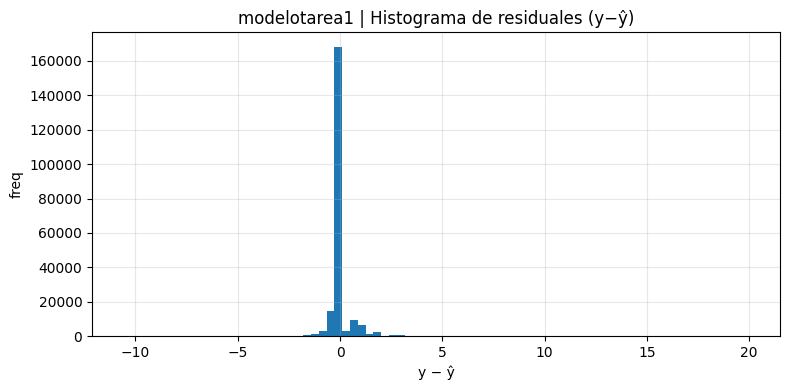

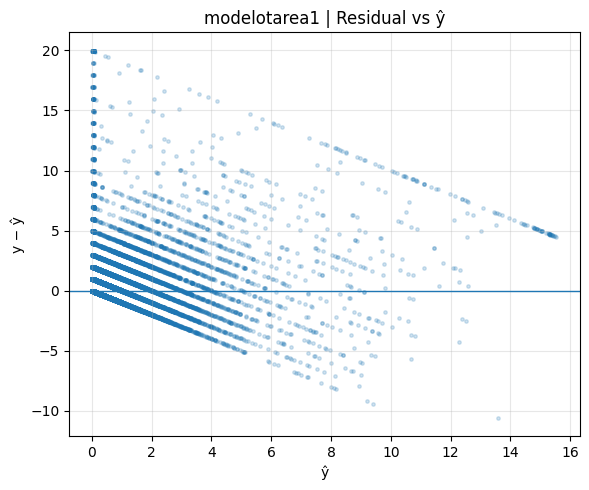

In [55]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import joblib

OUT_DIR = "intermediate_data"

train_df = pd.read_parquet(f"{OUT_DIR}/train.parquet")
valid_df = pd.read_parquet(f"{OUT_DIR}/valid.parquet")
test_X   = pd.read_parquet(f"{OUT_DIR}/test_features.parquet")

with open(f"{OUT_DIR}/meta.json") as f:
    meta = json.load(f)

feature_cols = meta["feature_cols"]

# -----------------------
# 1) Baseline LightGBM simple (time + IDs + lags básicos)
# -----------------------
basic_cols = []
for c in ["date_block_num", "month", "year", "shop_id", "item_id", "cnt_lag_1", "cnt_lag_12"]:
    if c in train_df.columns:
        basic_cols.append(c)

X_train_b = train_df[basic_cols]
y_train = train_df["y"].astype(np.float32)

X_valid_b = valid_df[basic_cols]
y_valid = valid_df["y"].astype(np.float32)

cat_features_b = [c for c in ["shop_id", "item_id", "month", "year"] if c in basic_cols]

baseline_lgbm = lgb.LGBMRegressor(
    n_estimators=4000,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42
)

baseline_lgbm.fit(
    X_train_b, y_train,
    eval_set=[(X_valid_b, y_valid)],
    eval_metric="rmse",
    categorical_feature=cat_features_b,
    callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=True)]
)

pred_valid_base = np.clip(baseline_lgbm.predict(X_valid_b).astype(np.float32), 0, 20)
rmse_base = float(np.sqrt(np.mean((pred_valid_base - y_valid.values) ** 2)))
print("RMSE valid (baseline_lgbm):", rmse_base)
print("Best iteration baseline:", baseline_lgbm.best_iteration_)

# Guardar baseline
joblib.dump(
    {"model": baseline_lgbm, "basic_cols": basic_cols, "cat_features": cat_features_b, "meta": meta},
    "baseline_lgbm.pkl"
)
print("Guardado: baseline_lgbm.pkl")

# -----------------------
# 2) Cargar modelo principal (hurdle) y predecir en valid
# -----------------------
bundle = joblib.load("model_tarea1.pkl")
clf = bundle["clf"]
reg = bundle["reg"]
feat_h = bundle["feature_cols"]

X_valid_h = valid_df[feat_h]

p_valid = clf.predict_proba(X_valid_h)[:, 1].astype(np.float32)
mu_valid = reg.predict(X_valid_h).astype(np.float32)
pred_valid_hurdle = np.clip(p_valid * mu_valid, 0, 20)

rmse_hurdle = float(np.sqrt(np.mean((pred_valid_hurdle - y_valid.values) ** 2)))
print("RMSE valid (model_hurdle):", rmse_hurdle)

# -----------------------
# Helpers para gráficas
# -----------------------
def plot_calibration_by_decile(y_true, y_pred, title):
    df = pd.DataFrame({"y": y_true, "yhat": y_pred}).dropna()
    df["decile"] = pd.qcut(df["yhat"], 10, duplicates="drop")
    rep = df.groupby("decile").agg(y_mean=("y","mean"), yhat_mean=("yhat","mean")).reset_index()

    x = np.arange(len(rep))
    plt.figure(figsize=(10,4))
    plt.plot(x, rep["yhat_mean"], marker="o", label="Predicho (mean)")
    plt.plot(x, rep["y_mean"], marker="o", label="Real (mean)")
    plt.title(title)
    plt.xlabel("Decil (0=ŷ más bajo, último=ŷ más alto)")
    plt.ylabel("Promedio")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_tail_underestimation(y_true, y_pred, title):
    df = pd.DataFrame({"y": y_true, "yhat": y_pred}).dropna()

    thresholds = [0, 5, 10, 15]
    rows = []
    for thr in thresholds:
        sub = df[df["y"] >= thr]
        rows.append((thr, len(sub), sub["y"].mean(), sub["yhat"].mean()))
    rep = pd.DataFrame(rows, columns=["thr", "n", "mean_y", "mean_yhat"])

    x = np.arange(len(rep))
    w = 0.35
    plt.figure(figsize=(10,4))
    plt.bar(x - w/2, rep["mean_y"], width=w, label="Real (mean)")
    plt.bar(x + w/2, rep["mean_yhat"], width=w, label="Predicho (mean)")
    plt.title(title)
    plt.xticks(x, [f"y≥{t}\n(n={n})" for t,n in zip(rep["thr"], rep["n"])])
    plt.ylabel("Promedio")
    plt.grid(True, axis="y", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_scatter_high(y_true, y_pred, thr, title):
    df = pd.DataFrame({"y": y_true, "yhat": y_pred}).dropna()
    df = df[df["y"] >= thr]
    plt.figure(figsize=(6,6))
    plt.scatter(df["y"], df["yhat"], s=6, alpha=0.2)
    mx = max(df["y"].max() if len(df) else 20, 20)
    plt.plot([0, mx], [0, mx], linewidth=1)
    plt.title(title)
    plt.xlabel("y real")
    plt.ylabel("y predicho")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, title_prefix):
    res = y_true - y_pred
    plt.figure(figsize=(8,4))
    plt.hist(res, bins=80)
    plt.title(f"{title_prefix} | Histograma de residuales (y−ŷ)")
    plt.xlabel("y − ŷ")
    plt.ylabel("freq")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,5))
    plt.scatter(y_pred, res, s=6, alpha=0.2)
    plt.axhline(0, linewidth=1)
    plt.title(f"{title_prefix} | Residual vs ŷ")
    plt.xlabel("ŷ")
    plt.ylabel("y − ŷ")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# -----------------------
# 3) Gráficas comparativas
# -----------------------
print("Comparación RMSE (validación)")
print("baseline_lgbm:", rmse_base)
print("modelo tarea 1:", rmse_hurdle)

plot_calibration_by_decile(y_valid.values, pred_valid_base, "Baseline LGBM | Calibración por deciles")
plot_calibration_by_decile(y_valid.values, pred_valid_hurdle, "modelotarea1 | Calibración por deciles")

plot_tail_underestimation(y_valid.values, pred_valid_base, "Baseline LGBM | Subestimación en cola (por umbral)")
plot_tail_underestimation(y_valid.values, pred_valid_hurdle, "modelotarea1 | Subestimación en cola (por umbral)")

plot_scatter_high(y_valid.values, pred_valid_base, 5, "Baseline LGBM | y real vs y predicho (solo y≥5)")
plot_scatter_high(y_valid.values, pred_valid_hurdle, 5, "modelotarea1 | y real vs y predicho (solo y≥5)")

plot_residuals(y_valid.values, pred_valid_base, "Baseline LGBM")
plot_residuals(y_valid.values, pred_valid_hurdle, "modelotarea1")
